In [1]:
# Bloque 1: Importar librerías
import yfinance as yf
import pandas as pd
import ta
import numpy as np

In [2]:
# Función optimizada para obtener datos
def get_stock_data(ticker, period, interval):
    data = yf.download(ticker, period=period, interval=interval)
    data.columns = data.columns.droplevel(1)
    data.reset_index(inplace=True)
    data.rename(columns={"Datetime": "Date"}, inplace=True)

    # Convertir y extraer características de fecha
    data["Date"] = pd.to_datetime(data["Date"])
    data["Day"] = data["Date"].dt.day
    data["Month"] = data["Date"].dt.month
    data["Hour"] = data["Date"].dt.hour
    data["Year"] = data["Date"].dt.year
    data["Dia_de_la_Semana"] = data["Date"].dt.weekday
    data["Dia_del_Año"] = data["Date"].dt.dayofyear

    # Asignar 1 si el cierre es mayor que el cierre anterior (verde), 0 si es menor o igual (rojo)
    data["Volumen_Color_Num"] = (data["Close"] > data["Close"].shift(1)).astype(int)

    return data

ticker = "GOOG"
period = "730d"  
interval = "1h"  # Datos por hora

data_2w = get_stock_data(ticker, period, interval)

data_2w.head(-1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume,Day,Month,Hour,Year,Dia_de_la_Semana,Dia_del_Año,Volumen_Color_Num
0,2022-05-04 13:30:00+00:00,116.286499,118.071999,115.856995,118.003502,299667,4,5,13,2022,2,124,0
1,2022-05-04 14:30:00+00:00,115.922501,116.645485,115.738503,116.224998,116813,4,5,14,2022,2,124,0
2,2022-05-04 15:30:00+00:00,117.689003,117.694496,115.750000,115.949501,90097,4,5,15,2022,2,124,1
3,2022-05-04 16:30:00+00:00,118.626503,118.769997,117.433998,117.650002,131949,4,5,16,2022,2,124,1
4,2022-05-04 17:30:00+00:00,118.756493,119.780006,117.748924,118.683571,226234,4,5,17,2022,2,124,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5080,2025-04-01 14:30:00+00:00,159.240005,159.570007,157.509995,157.550003,2987758,1,4,14,2025,1,91,1
5081,2025-04-01 15:30:00+00:00,159.328400,160.080002,159.070007,159.244995,2352853,1,4,15,2025,1,91,1
5082,2025-04-01 16:30:00+00:00,158.820099,159.527100,158.639999,159.324997,1632711,1,4,16,2025,1,91,0
5083,2025-04-01 17:30:00+00:00,157.600006,159.130005,157.399994,158.809998,1670358,1,4,17,2025,1,91,0


In [3]:
def calculate_indicators(data):
    # ===================== 📌 MEDIAS MÓVILES =====================
    data["EMA12"] = data["Close"].ewm(span=12, adjust=False).mean()
    data["EMA26"] = data["Close"].ewm(span=26, adjust=False).mean()
    data["EMA50"] = data["Close"].ewm(span=50, adjust=False).mean()
    data["SMA50"] = data["Close"].rolling(window=50).mean()

    # ===================== 🔥 BOLLINGER BANDS =====================
    data["BB_upper"] = (data["Close"].rolling(window=20).mean()+ 2 * data["Close"].rolling(window=20).std())
    data["BB_lower"] = (data["Close"].rolling(window=20).mean()- 2 * data["Close"].rolling(window=20).std())
    data["BBW"] = (data["BB_upper"] - data["BB_lower"]) / data["Close"]  # Ancho de BB

    # ===================== 📊 VOLUMEN =====================
    data["Volume_MA"] = data["Volume"].rolling(window=20).mean()
    data["Vol_Ratio_10h"] = data["Volume"] / data["Volume"].rolling(window=10).mean()

    # ===================== 🔄 CAMBIOS PORCENTUALES =====================
    data["Hourly_Return"] = data["Close"].pct_change() * 100
    data["Cumulative_Return"] = (data["Close"].pct_change(periods=5) * 100)  # Cambio acumulado en 5 horas

    # ===================== 📈 MACD =====================
    data["MACD"] = data["EMA12"] - data["EMA26"]
    data["MACD_Signal"] = data["MACD"].ewm(span=9, adjust=False).mean()

    # ===================== 📊 RSI =====================
    data["RSI"] = ta.momentum.rsi(data["Close"], window=14)

    # ===================== 📉 ATR =====================
    data["ATR"] = ta.volatility.average_true_range(data["High"], data["Low"], data["Close"], window=14)

    # ===================== 📊 ADX (Índice de Dirección Media) =====================
    data["ADX"] = ta.trend.adx(data["High"], data["Low"], data["Close"], window=14)

    # ===================== 🔄 ESTOCÁSTICO =====================
    data["Stoch_K"] = ta.momentum.stoch(data["High"], data["Low"], data["Close"], window=14, smooth_window=3)
    data["Stoch_D"] = ta.momentum.stoch_signal(data["High"], data["Low"], data["Close"], window=14, smooth_window=3)

    # ===================== 🔥 MOMENTUM =====================
    data["MOM"] = ta.momentum.roc(data["Close"], window=10)

    # ===================== 🔎 OBV (On-Balance Volume) =====================
    data["OBV"] = ta.volume.on_balance_volume(data["Close"], data["Volume"])

    # ===================== 💰 CMF (Chaikin Money Flow) =====================
    data["CMF"] = ta.volume.chaikin_money_flow(data["High"], data["Low"], data["Close"], data["Volume"], window=20)

    # Eliminar filas con NaN generadas por indicadores
    data.dropna(inplace=True)

    return data


# Aplicar la función al dataframe
data_2w = calculate_indicators(data_2w)

# Mostrar primeras filas con indicadores
print(data_2w.head())

Price                      Date       Close        High         Low  \
49    2022-05-13 13:30:00+00:00  116.239746  116.428406  114.000000   
50    2022-05-13 14:30:00+00:00  116.868851  116.868851  115.780006   
51    2022-05-13 15:30:00+00:00  117.670998  118.084999  116.890503   
52    2022-05-13 16:30:00+00:00  117.308495  117.849503  117.018005   
53    2022-05-13 17:30:00+00:00  115.493507  117.281006  115.334755   

Price        Open  Volume  Day  Month  Hour  Year  ...      MACD  MACD_Signal  \
49     114.349998  354719   13      5    13  2022  ... -0.543365    -0.633670   
50     116.215248  178379   13      5    14  2022  ... -0.248924    -0.556721   
51     116.900002  205377   13      5    15  2022  ...  0.048589    -0.435659   
52     117.641525  105642   13      5    16  2022  ...  0.252212    -0.298085   
53     117.277504  131401   13      5    17  2022  ...  0.264086    -0.185651   

Price        RSI       ATR        ADX     Stoch_K    Stoch_D       MOM  \
49     58.03

In [4]:
# 📌 Asegurar que 'Date' sea de tipo datetime
data_2w["Date"] = pd.to_datetime(data_2w["Date"])

# 📌 Calcular el cambio de RSI en una semana
data_2w["RSI_change_1w"] = data_2w["RSI"] - data_2w["RSI"].shift(70)
data_2w["RSI_change_2w"] = data_2w["RSI"] - data_2w["RSI"].shift(140)
data_2w["ADX_change_1w"] = data_2w["ADX"] - data_2w["ADX"].shift(70)
data_2w["ADX_change_2w"] = data_2w["ADX"] - data_2w["ADX"].shift(140)
data_2w["Volume_MA_change_1w"] = data_2w["Volume_MA"] - data_2w["Volume_MA"].shift(70)

In [5]:
# ===================== 📌 CAMBIO PORCENTUAL PASADO =====================
data_2w["Past_Change_1d"] = ((data_2w["Close"] - data_2w["Close"].shift(7)) / data_2w["Close"].shift(7) * 100)
data_2w["Past_Change_2d"] = ((data_2w["Close"] - data_2w["Close"].shift(14)) / data_2w["Close"].shift(14) * 100)
data_2w["Past_Change_1w"] = ((data_2w["Close"] - data_2w["Close"].shift(35)) / data_2w["Close"].shift(35) * 100)
data_2w["Past_Change_2w"] = ((data_2w["Close"] - data_2w["Close"].shift(70)) / data_2w["Close"].shift(70) * 100)

data_2w["Past_Change_1m"] = ((data_2w["Close"] - data_2w["Close"].shift(140)) / data_2w["Close"].shift(140) * 100)
data_2w["Past_Change_2m"] = ((data_2w["Close"] - data_2w["Close"].shift(280)) / data_2w["Close"].shift(280) * 100)
data_2w["Past_Change_3m"] = ((data_2w["Close"] - data_2w["Close"].shift(420)) / data_2w["Close"].shift(420) * 100)
data_2w["Past_Change_6m"] = ((data_2w["Close"] - data_2w["Close"].shift(840)) / data_2w["Close"].shift(840) * 100)

# ===================== 📌 CAMBIO PORCENTUAL FUTURO (2 SEMANAS) =====================
data_2w["Future_Change_2w"] = ((data_2w["Close"].shift(-70) - data_2w["Close"]) / data_2w["Close"] * 100)

In [6]:
# ===================== 📌 FUNCIÓN PARAAR CAMBIOS =====================
def classify_change(percentage, percentiles):
    if percentage <= percentiles[0]:
        return 0  # Venta Muy Fuerteelif percentage <= percentiles[1]
    elif percentage <= percentiles[1]:
        return 1  # Venta
    else:
        return 2


# ===================== 📌 CALCULAR PERCENTILES DINÁMICOS =====================
percentiles_1w = np.percentile(data_2w["Past_Change_1w"].dropna(), [25, 75])
percentiles_2w = np.percentile(data_2w["Past_Change_2w"].dropna(), [30, 70])
percentiles_1m = np.percentile(data_2w["Past_Change_1m"].dropna(), [25, 75])
percentiles_2m = np.percentile(data_2w["Past_Change_2m"].dropna(), [35, 75])
percentiles_3m = np.percentile(data_2w["Past_Change_3m"].dropna(), [35, 75])
percentiles_6m = np.percentile(data_2w["Past_Change_6m"].dropna(), [35, 75])

In [7]:
# ===================== 📌 APLICAR CLASIFICACIÓN =====================
data_2w["Past_Class_1w"] = data_2w["Past_Change_1w"].apply(lambda x: classify_change(x, percentiles_1w))
data_2w["Past_Class_2w"] = data_2w["Past_Change_2w"].apply(lambda x: classify_change(x, percentiles_2w))
data_2w["Past_Class_1m"] = data_2w["Past_Change_1m"].apply(lambda x: classify_change(x, percentiles_1m))
data_2w["Past_Class_2m"] = data_2w["Past_Change_2m"].apply(lambda x: classify_change(x, percentiles_2m))
data_2w["Past_Class_2m"] = data_2w["Past_Change_2m"].apply(lambda x: classify_change(x, percentiles_3m))
data_2w["Past_Class_2m"] = data_2w["Past_Change_2m"].apply(lambda x: classify_change(x, percentiles_6m))

data_2w["Future_Class_2w"] = data_2w["Future_Change_2w"].apply(lambda x: classify_change(x, percentiles_2w))

data_2w["Volatility_Spike_VH"] = (data_2w["Past_Change_2w"] <= percentiles_2w[0]).astype(int)
data_2w["Volatility_Spike_H"] = (data_2w["Past_Change_2w"] <= percentiles_2w[1]).astype(int)
data_2w["Volatility_Spike_I"] = (data_2w["Past_Change_2w"] <= percentiles_2w[1]).astype(int)

data_2w["Volatility_Spike_VH_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[0]).astype(int)
data_2w["Volatility_Spike_H_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[1]).astype(int)
data_2w["Volatility_Spike_I_m"] = (data_2w["Past_Change_2m"] <= percentiles_2m[1]).astype(int)


# ===================== 📌 MOSTRAR RESULTADOS =====================
print("Percentiles de cambios pasados (2 semanas):", percentiles_2w)

Percentiles de cambios pasados (2 semanas): [-2.2332761   3.72115383]


In [8]:
def mark_previous_hours(data, column_name, percentiles, horas_a_marcar=84):
    # Crear las nuevas columnas e inicializarlas con 0
    data[f"previousd_strongsell"] = 0
    data[f"previousd_strongbuy"] = 0

    # Iterar sobre los datos para marcar las horas previas
    for i in range(horas_a_marcar, len(data)-7):  # Comenzamos desde el índice de horas_a_marcar
        # Verificar si el cambio porcentual pasado cae por debajo del percentil 15 (fuerte caída)
        if data[column_name].iloc[i] <= percentiles[0]:
            # Marcar las horas previas como 1 en 'previousd_strongsell'
            data.loc[data.index[i - horas_a_marcar : i], "previousd_strongsell"] = 1

        # Verificar si el cambio porcentual pasado es mayor que el percentil 58 (subida moderada)
        if data[column_name].iloc[i] >= percentiles[1]:
            # Marcar las horas previas como 1 en 'previousd_buy'
            data.loc[data.index[i - horas_a_marcar : i], "previousd_strongbuy"] = 1

    # Devolver el DataFrame con las nuevas columnas
    return data


data_2w = mark_previous_hours(data_2w, "Past_Change_2w", percentiles_2w, 84)

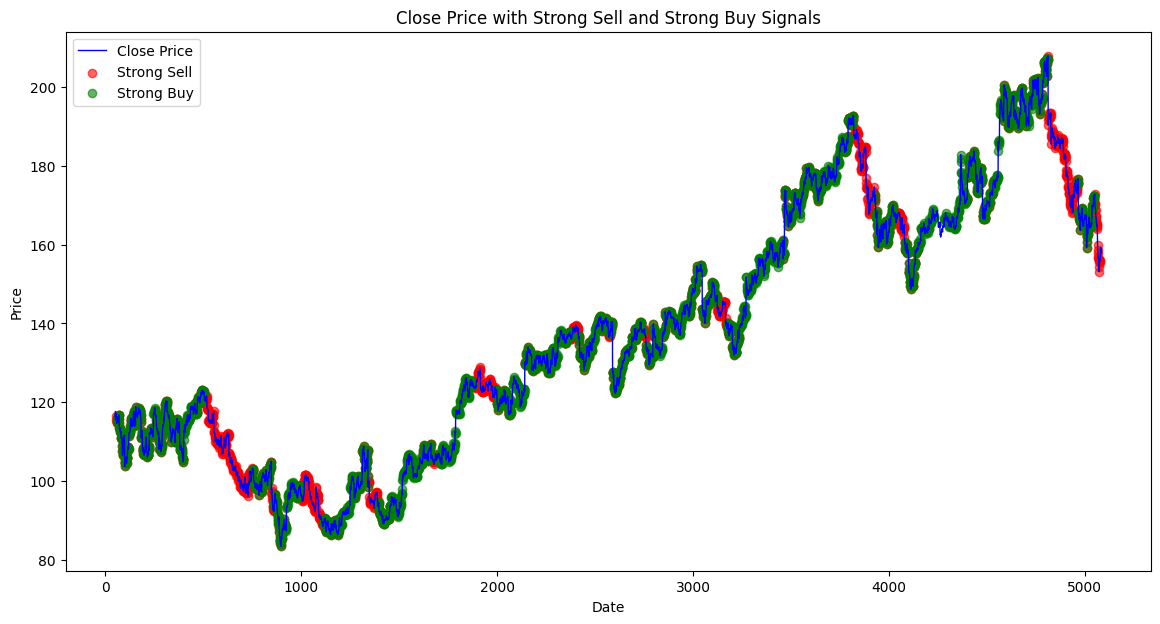

In [9]:
import matplotlib.pyplot as plt

# Graficar 'Close'
plt.figure(figsize=(14, 7))
plt.plot(data_2w['Close'], label='Close Price', color='blue', linewidth=1)

# Marcar los puntos de 'previousd_strongsell' en rojo y 'previousd_strongbuy' en verde
plt.scatter(data_2w.index[data_2w['previousd_strongsell'] == 1], 
            data_2w['Close'][data_2w['previousd_strongsell'] == 1], 
            marker='o', color='red', label='Strong Sell', alpha=0.6)

plt.scatter(data_2w.index[data_2w['previousd_strongbuy'] == 1], 
            data_2w['Close'][data_2w['previousd_strongbuy'] == 1], 
            marker='o', color='green', label='Strong Buy', alpha=0.6)

# Añadir leyenda y títulos
plt.title('Close Price with Strong Sell and Strong Buy Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Mostrar el gráfico
plt.show()

In [10]:
print(data_2w["previousd_strongsell"].value_counts())
print(data_2w["previousd_strongbuy"].value_counts())

previousd_strongsell
1    3621
0    1416
Name: count, dtype: int64
previousd_strongbuy
1    3906
0    1131
Name: count, dtype: int64


In [11]:
def classify_trend(percentage, percentiles):
    if percentage <= percentiles[0]:  # Por debajo del percentil 25
        return 0  # Tendencia negativa
    elif percentage <= percentiles[1]:  # Entre percentil 25 y 75
        return 1  # Tendencia neutral
    else:  # Por encima del percentil 75
        return 2  # Tendencia positiva

percentiles_trend_1w = np.percentile(data_2w["Past_Change_1w"].dropna(), [35, 65])
percentiles_trend_2w = np.percentile(data_2w["Past_Change_2w"].dropna(), [30, 70])
percentiles_trend_1m = np.percentile(data_2w["Past_Change_1m"].dropna(), [30, 70])
percentiles_trend_2m = np.percentile(data_2w["Past_Change_2m"].dropna(), [30, 70])
percentiles_trend_3m = np.percentile(data_2w["Past_Change_3m"].dropna(), [35, 65])
percentiles_trend_6m = np.percentile(data_2w["Past_Change_6m"].dropna(), [40, 60])

In [12]:
def assign_period_trends(data, fecha_col='Date', close_col='Close'):
    # Ordenar por fecha (ascendente)
    data = data.sort_values(fecha_col).copy()
    
    # Definir periodos en términos de número de observaciones
    periods = {
        '6m': 840,
        '3m': 420,
        '2m': 280,
        '1m': 140,
        '2w': 70,
        '1w': 35
    }
    
    # Obtener el número total de registros
    num_data = len(data)
    
    # Para cada periodo, dividir los datos en bloques de tamaño específico
    for period_name, period_size in periods.items():
        trend_col = f'Period_Trend_{period_name}'
        data[trend_col] = np.nan
        
        # Dividir los datos en bloques de tamaño period_size
        for i in range(0, num_data, period_size):
            # Seleccionar los datos en este bloque
            period_data = data.iloc[i:i+period_size]
            
            # Si el bloque tiene al menos dos datos, calcular la tendencia
            if len(period_data) >= 2:
                start_price = period_data[close_col].iloc[0]
                end_price = period_data[close_col].iloc[-1]
                change_pct = ((end_price - start_price) / start_price) * 100
                
                # Clasificar la tendencia (usando percentiles globales)
                if period_name == '1w':
                    trend = classify_trend(change_pct, percentiles_trend_1w)
                elif period_name == '2w':
                    trend = classify_trend(change_pct, percentiles_trend_2w)
                elif period_name == '1m':
                    trend = classify_trend(change_pct, percentiles_trend_1m)
                elif period_name == '2m':
                    trend = classify_trend(change_pct, percentiles_trend_2m)
                elif period_name == '3m':
                    trend = classify_trend(change_pct, percentiles_trend_3m)
                elif period_name == '6m':
                    trend = classify_trend(change_pct, percentiles_trend_6m)
                
                # Asignar la tendencia a todo el bloque
                data.loc[period_data.index, trend_col] = trend
    
    return data

# Aplicar la función
data_2w = assign_period_trends(data_2w)

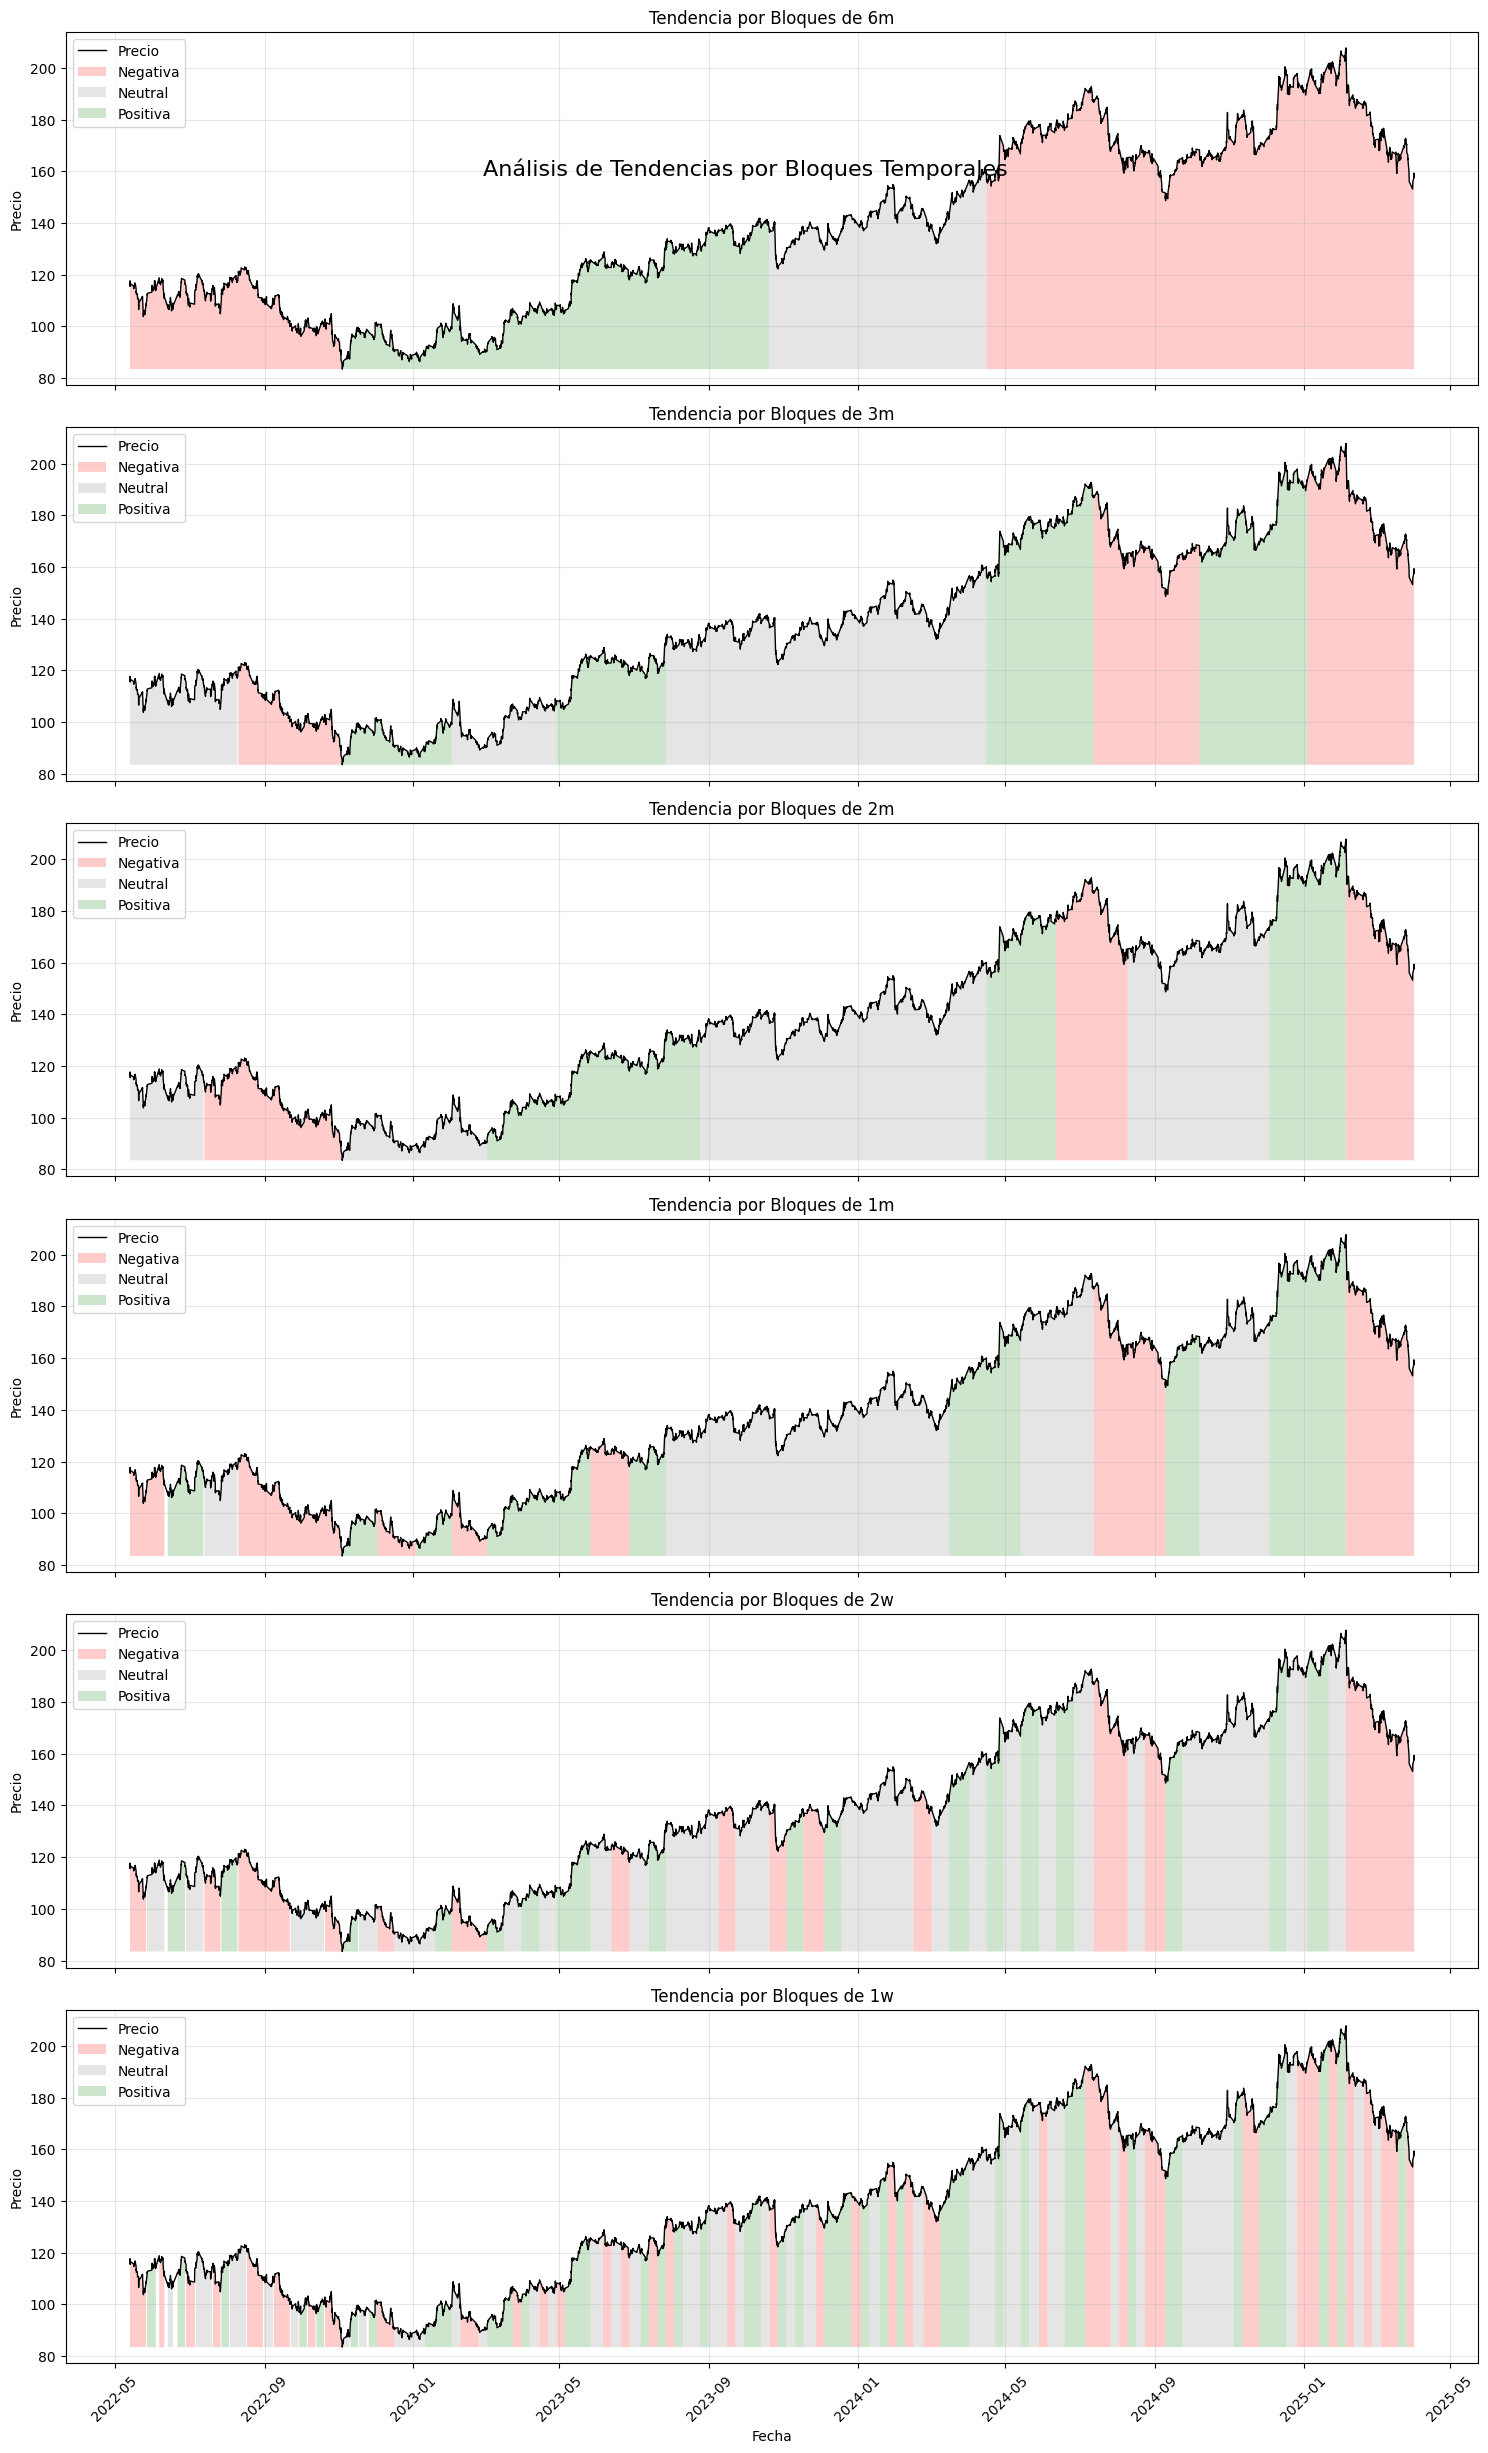

In [13]:
# Definir periodos de forma global
periods = {
    '6m': 840,
    '3m': 420,
    '2m': 280,
    '1m': 140,
    '2w': 70,
    '1w': 36
}

# Llamar a la función con la variable global
data_2w = assign_period_trends(data_2w)

# Crear figura
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 25), sharex=True)

# Graficar cada periodo
for ax, (period_name, _) in zip(axes, periods.items()):
    trend_col = f'Period_Trend_{period_name}'
    
    # Graficar precio
    ax.plot(data_2w['Date'], data_2w['Close'], color='black', linewidth=1, label='Precio')
    
    # Colorear por tendencia
    for trend_val, color in [(0, 'red'), (1, 'gray'), (2, 'green')]:
        mask = data_2w[trend_col] == trend_val
        ax.fill_between(data_2w['Date'], 
                       data_2w['Close'].min(), 
                       data_2w['Close'],
                       where=mask,
                       facecolor=color,
                       alpha=0.2,
                       label=['Negativa', 'Neutral', 'Positiva'][trend_val])
    
    ax.set_title(f'Tendencia por Bloques de {period_name}', fontsize=12)
    ax.set_ylabel('Precio')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.xlabel('Fecha')
plt.suptitle('Análisis de Tendencias por Bloques Temporales', fontsize=16, y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
from scipy.signal import argrelextrema

def mark_multi_window_trade_signals(data, windows=[14,21,35, 70, 140, 420]):
    """
    Detecta picos importantes en diferentes escalas de tiempo.
    - windows: Lista con los diferentes períodos a analizar.
    """
    data = data.copy()
    
    for window in windows:
        # Crear nuevas columnas para cada ventana
        buy_col = f"buy_signal_w{window}"
        sell_col = f"sell_signal_w{window}"
        data[buy_col] = 0
        data[sell_col] = 0

        # Encontrar mínimos y máximos locales en la ventana dada
        min_indexes = argrelextrema(data["Close"].values, np.less, order=window)[0]  # V normales (comprar)
        max_indexes = argrelextrema(data["Close"].values, np.greater, order=window)[0]  # V invertidas (vender)

        # Marcar picos con margen de ±1 día
        for i in min_indexes:
            data.loc[data.index[max(0, i - 1) : min(len(data), i + 2)], buy_col] = 1
        for i in max_indexes:
            data.loc[data.index[max(0, i - 1) : min(len(data), i + 2)], sell_col] = 1

    return data

# Aplicar la función a los datos
data_2w = mark_multi_window_trade_signals(data_2w, windows=[14,21,35, 70, 140, 420])

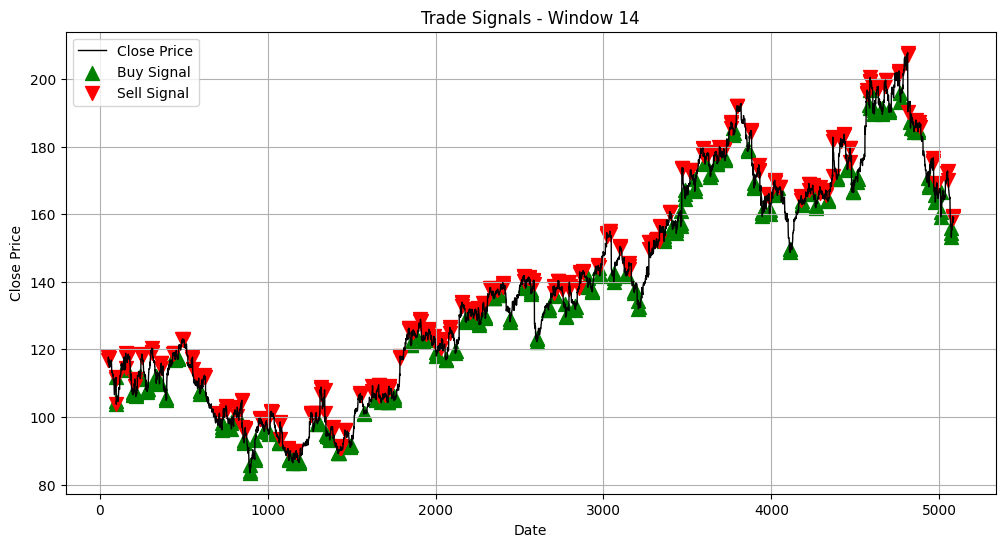

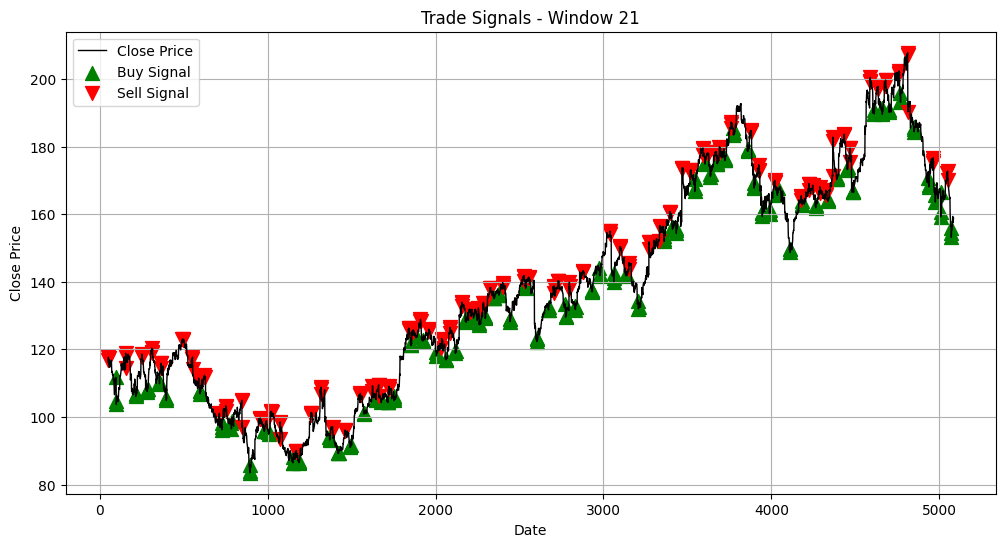

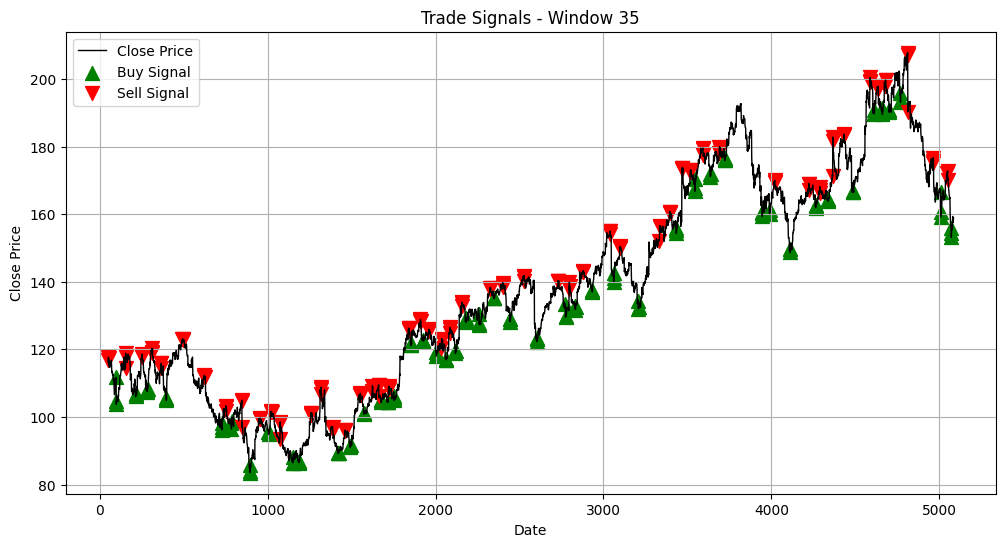

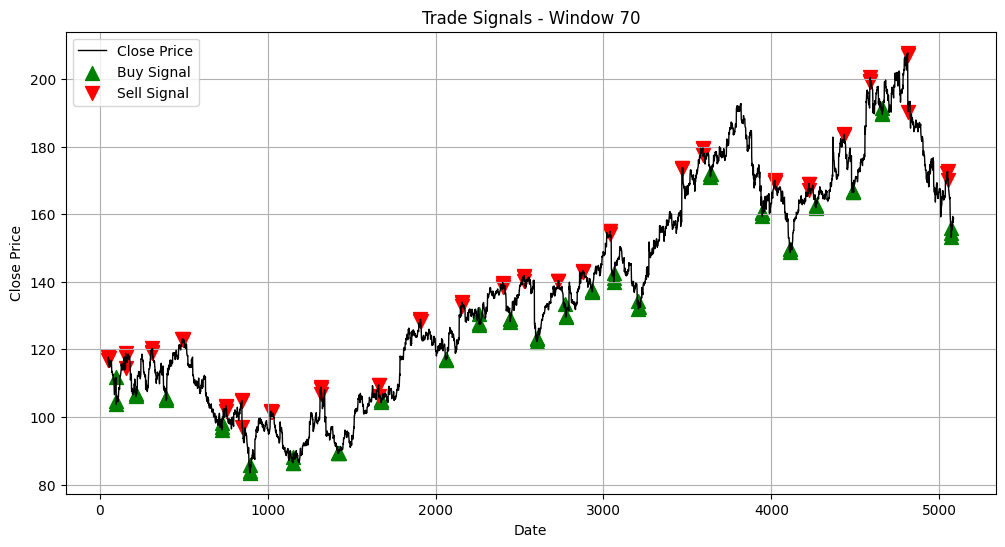

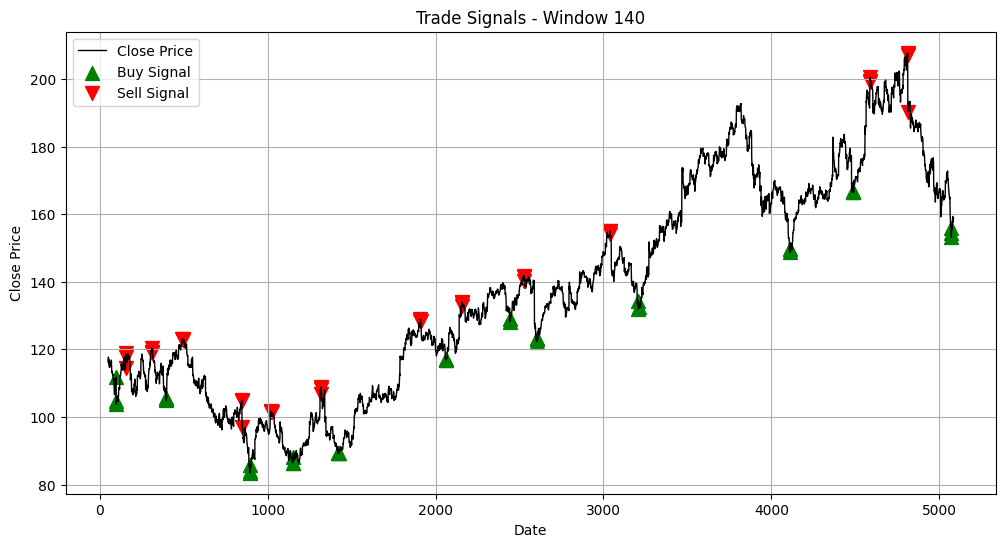

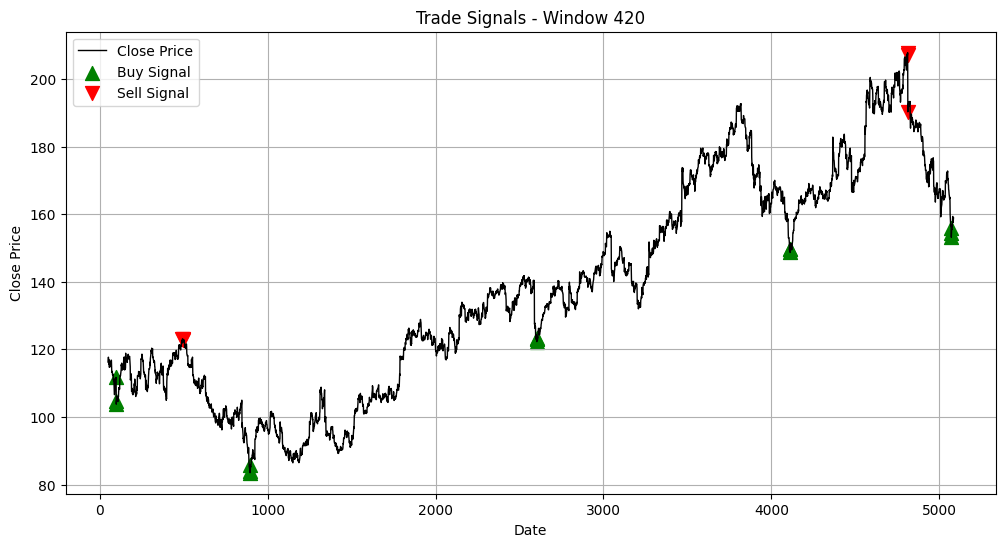

In [15]:
import matplotlib.pyplot as plt

def plot_trade_signals(data, windows=[14,21,35, 70, 140, 420]):
    """
    Genera una gráfica por cada ventana de tiempo mostrando los buy y sell signals.
    """
    for window in windows:
        buy_col = f"buy_signal_w{window}"
        sell_col = f"sell_signal_w{window}"

        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data["Close"], label="Close Price", color="black", linewidth=1)

        # Puntos de compra (verde)
        buy_signals = data[data[buy_col] == 1]
        plt.scatter(buy_signals.index, buy_signals["Close"], color="green", marker="^", label="Buy Signal", s=100)

        # Puntos de venta (rojo)
        sell_signals = data[data[sell_col] == 1]
        plt.scatter(sell_signals.index, sell_signals["Close"], color="red", marker="v", label="Sell Signal", s=100)

        plt.title(f"Trade Signals - Window {window}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid(True)
        plt.show()

# Llamar a la función para graficar
plot_trade_signals(data_2w, windows=[14,21,35, 70, 140, 420])

In [16]:
correlation_matrix = data_2w.corr()
# 🔹 Obtener las variables con correlación débil con 'Future_Class_2w'
low_corr_features = correlation_matrix.index[
    correlation_matrix["Future_Class_2w"].between(-0.1, 0.1)
].difference(["Date", "Close"])

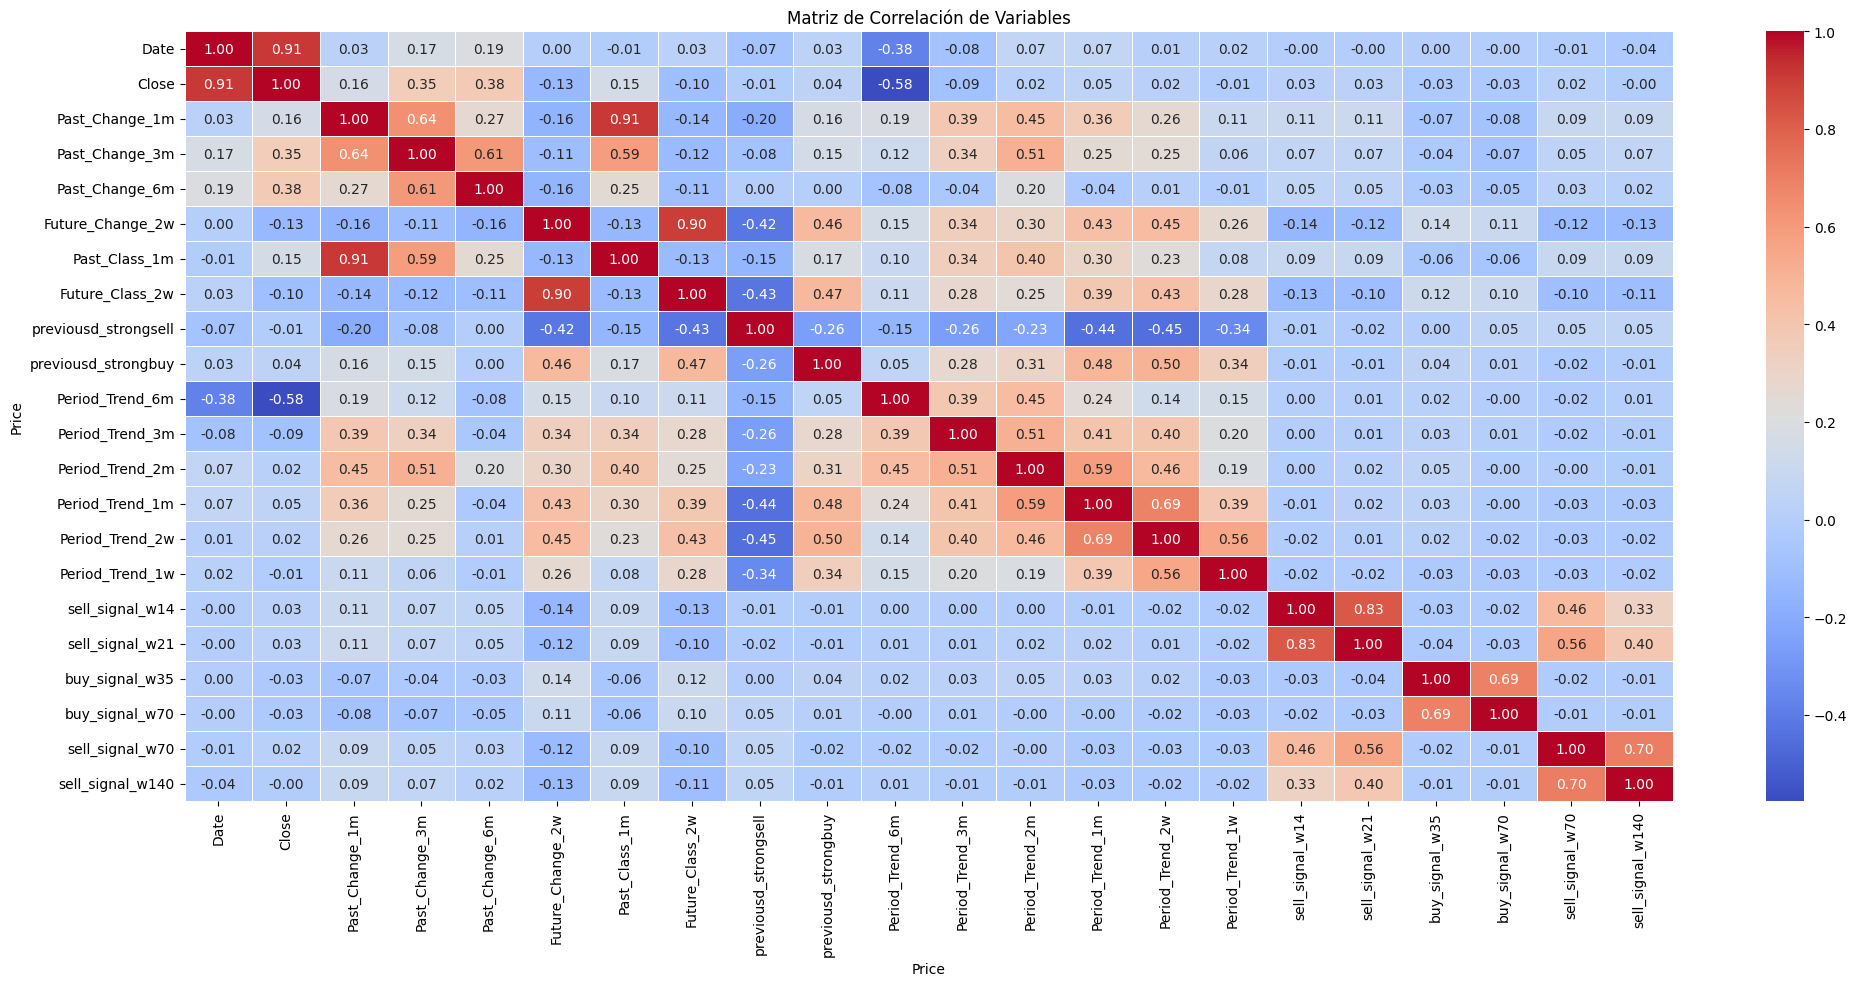

In [17]:
import seaborn as sns

# 📌 Eliminar las columnas con baja correlación
data_view = data_2w.drop(columns=data_2w[low_corr_features])

correlation_matrix = data_view.corr()

# Configurar la figura
plt.figure(figsize=(24, 10))

# Crear un heatmap con Seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

# Título del gráfico
plt.title("Matriz de Correlación de Variables")

# Mostrar la gráfica
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import optuna
from sklearn.model_selection import cross_val_score

# Eliminar valores nulos
data_train_2w = data_2w.dropna()

# Preparar los datos
X = data_train_2w.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y = data_train_2w["Future_Class_2w"]

# Normalización de las características usando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled_2w = scaler.fit_transform(X)

# Definir la fecha de corte (por ejemplo, 2024-01-01)
fecha_corte = "2024-05-01"

# Crear el conjunto de entrenamiento (hasta la fecha de corte)
train_data = data_train_2w[data_train_2w["Date"] < fecha_corte]
test_data = data_train_2w[data_train_2w["Date"] >= fecha_corte]

# Preparar los datos de entrenamiento y prueba
X_train_2w = train_data.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y_train_2w = train_data["Future_Class_2w"]
X_test_2w = test_data.drop(columns=["Future_Change_2w", "Future_Class_2w", "Date"])
y_test_2w = test_data["Future_Class_2w"]

# Función para optimizar modelos con Optuna
def objective(trial, model_name, X_train, y_train):
    if model_name == "Random Forest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "random_state": 42,
            "n_jobs": -1,
        }
        model = RandomForestClassifier(**params)

    elif model_name == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 0.5),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "random_state": 42,
            "n_jobs": -1,
        }
        model = xgb.XGBClassifier(**params)

    elif model_name == "Gradient Boosting":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "random_state": 42,
        }
        model = GradientBoostingClassifier(**params)

    elif model_name == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "max_depth": trial.suggest_int("max_depth", -1, 10),
            "num_leaves": trial.suggest_int("num_leaves", 10, 100),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "objective": "multiclass",
            "num_class": 3,
            "force_col_wise": True,
            "random_state": 42,
            "n_jobs": -1,
            "verbose": -1,
        }
        model = lgb.LGBMClassifier(**params)

    # Evaluamos con cross-validation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy").mean()
    return score

# Optimizar modelos con Optuna
best_params = {}
for model_name in ["Random Forest", "XGBoost", "Gradient Boosting", "LightGBM"]:
    print(f"\n🔍 Optimizando {model_name}...")
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, model_name, X_train_2w, y_train_2w), n_trials=50)
    best_params[model_name] = study.best_params
    print(f"✅ Mejores parámetros para {model_name}: {study.best_params}")

# Crear modelos con los mejores parámetros encontrados
models = {
    "Random Forest": RandomForestClassifier(**best_params["Random Forest"]),
    "XGBoost": xgb.XGBClassifier(**best_params["XGBoost"]),
    "Gradient Boosting": GradientBoostingClassifier(**best_params["Gradient Boosting"]),
    "LightGBM": lgb.LGBMClassifier(**best_params["LightGBM"]),
}

c:\Python312\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-01 23:21:25,728] A new study created in memory with name: no-name-eb10ba89-8ab6-4e50-96c2-eeded4ec3c8b



🔍 Optimizando Random Forest...


[I 2025-04-01 23:21:26,476] Trial 0 finished with value: 0.5013638385662648 and parameters: {'n_estimators': 108, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5013638385662648.
[I 2025-04-01 23:21:26,945] Trial 1 finished with value: 0.507919764382681 and parameters: {'n_estimators': 73, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.507919764382681.
[I 2025-04-01 23:21:28,268] Trial 2 finished with value: 0.48674918955491453 and parameters: {'n_estimators': 207, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.507919764382681.
[I 2025-04-01 23:21:29,338] Trial 3 finished with value: 0.4994428328773886 and parameters: {'n_estimators': 185, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 0.507919764382681.


✅ Mejores parámetros para Random Forest: {'n_estimators': 297, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}

🔍 Optimizando XGBoost...


[I 2025-04-01 23:22:41,385] Trial 0 finished with value: 0.5298219817746417 and parameters: {'n_estimators': 144, 'learning_rate': 0.07129737920924513, 'max_depth': 10, 'subsample': 0.5762474394226391, 'colsample_bytree': 0.8560596951772251, 'gamma': 0.1211990793198448, 'min_child_weight': 1}. Best is trial 0 with value: 0.5298219817746417.
[I 2025-04-01 23:22:43,240] Trial 1 finished with value: 0.5594699320655673 and parameters: {'n_estimators': 229, 'learning_rate': 0.08393562597157302, 'max_depth': 4, 'subsample': 0.6810339393793639, 'colsample_bytree': 0.6297233881776627, 'gamma': 0.16155534724829945, 'min_child_weight': 8}. Best is trial 1 with value: 0.5594699320655673.
[I 2025-04-01 23:22:45,521] Trial 2 finished with value: 0.47631617968928275 and parameters: {'n_estimators': 95, 'learning_rate': 0.03617424175247867, 'max_depth': 7, 'subsample': 0.8092238769112402, 'colsample_bytree': 0.8425331777427263, 'gamma': 0.1610713936380826, 'min_child_weight': 3}. Best is trial 1 with

✅ Mejores parámetros para XGBoost: {'n_estimators': 247, 'learning_rate': 0.06902237981425904, 'max_depth': 5, 'subsample': 0.5682605742390296, 'colsample_bytree': 0.5565530298131498, 'gamma': 0.3412777024555911, 'min_child_weight': 10}

🔍 Optimizando Gradient Boosting...


[I 2025-04-01 23:26:00,677] Trial 0 finished with value: 0.5248065897554058 and parameters: {'n_estimators': 253, 'learning_rate': 0.05050017964757861, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.9378118668876008}. Best is trial 0 with value: 0.5248065897554058.
[I 2025-04-01 23:27:27,019] Trial 1 finished with value: 0.47515656174166443 and parameters: {'n_estimators': 144, 'learning_rate': 0.09138296419097366, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 3, 'subsample': 0.7600390678745874}. Best is trial 0 with value: 0.5248065897554058.
[I 2025-04-01 23:27:54,452] Trial 2 finished with value: 0.4505559684363715 and parameters: {'n_estimators': 106, 'learning_rate': 0.002857561623004221, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.9992382518589051}. Best is trial 0 with value: 0.5248065897554058.
[I 2025-04-01 23:28:58,646] Trial 3 finished with value: 0.46899842217374205 and parameters: {'n_estimator

In [ ]:
# Entrenar y evaluar cada modelo
predictions_2w = {}
model_metrics = {}

for name, model in models.items():
    print(f"Entrenando modelo: {name}")

    # Entrenar el modelo con el conjunto de entrenamiento completo
    model.fit(X_train_2w, y_train_2w)

    # Hacer predicciones sobre el conjunto de prueba
    y_pred = model.predict(X_test_2w)

    # Guardar predicciones y métricas
    predictions_2w[name] = y_pred
    report_2w = classification_report(
        y_test_2w, y_pred, output_dict=True, zero_division=1
    )
    model_metrics[name] = report_2w

# Imprimir los resultados
for name, metrics in model_metrics.items():
    print(f"\nReporte de clasificación para el modelo: {name}")
    print(metrics)

Entrenando modelo: Random Forest
Entrenando modelo: XGBoost
Entrenando modelo: Gradient Boosting
Entrenando modelo: LightGBM

Reporte de clasificación para el modelo: Random Forest
{'0': {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 443.0}, '1': {'precision': 0.5910780669144982, 'recall': 0.3970037453183521, 'f1-score': 0.4749813293502614, 'support': 801.0}, '2': {'precision': 0.237029501525941, 'recall': 0.8411552346570397, 'f1-score': 0.36984126984126986, 'support': 277.0}, 'accuracy': 0.3622616699539776, 'macro avg': {'precision': 0.6093691894801464, 'recall': 0.41271965999179727, 'f1-score': 0.28160753306384373, 'support': 1521.0}, 'weighted avg': {'precision': 0.6457006597772509, 'recall': 0.3622616699539776, 'f1-score': 0.3174924895171539, 'support': 1521.0}}

Reporte de clasificación para el modelo: XGBoost
{'0': {'precision': 0.8064516129032258, 'recall': 0.7336343115124153, 'f1-score': 0.7683215130023641, 'support': 443.0}, '1': {'precision': 0.6739864864864865

In [ ]:
import json

# Guardar métricas en un archivo JSON
with open("model_metrics.json", "w") as f:
    json.dump(model_metrics, f, indent=4)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

# Evaluar modelos con Accuracy, F1-score y Kappa
model_scores_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    accuracy = accuracy_score(y_test_2w, y_pred_2w)
    f1 = f1_score(y_test_2w, y_pred_2w, average="weighted")  # F1 ponderado
    kappa = cohen_kappa_score(y_test_2w, y_pred_2w)  # Cohen's Kappa

    model_scores_2w[model_name] = {"accuracy": accuracy, "f1_score": f1, "kappa": kappa}

# Ordenar modelos por precisión (puedes cambiar a 'f1_score' o 'kappa' si prefieres)
sorted_models_2w = sorted(
    model_scores_2w.items(), key=lambda x: x[1]["accuracy"], reverse=True
)

# Imprimir los 3 mejores modelos
print("🔹 Top 3 Modelos Basados en Precisión:")
for i, (model_name, scores) in enumerate(sorted_models_2w[:3]):
    print(
        f"{i + 1}. {model_name} - Precisión: {scores['accuracy']:.4f} | F1-Score: {scores['f1_score']:.4f} | Kappa: {scores['kappa']:.4f}"
    )

🔹 Top 3 Modelos Basados en Precisión:
1. Gradient Boosting - Precisión: 0.6095 | F1-Score: 0.6222 | Kappa: 0.3794
2. XGBoost - Precisión: 0.5957 | F1-Score: 0.6080 | Kappa: 0.3826
3. LightGBM - Precisión: 0.5556 | F1-Score: 0.5721 | Kappa: 0.3111


<Figure size 1000x600 with 0 Axes>

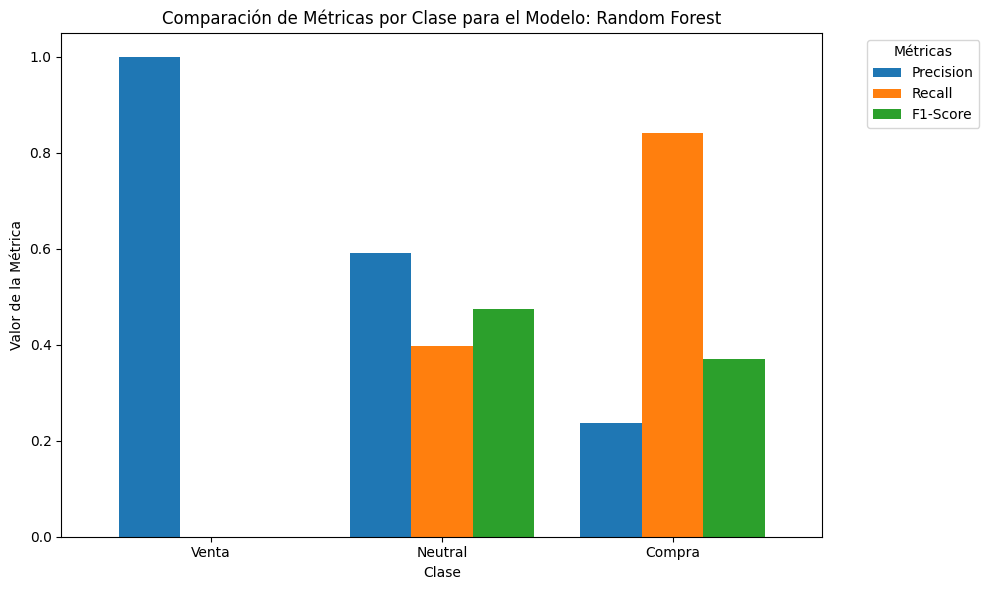

<Figure size 1000x600 with 0 Axes>

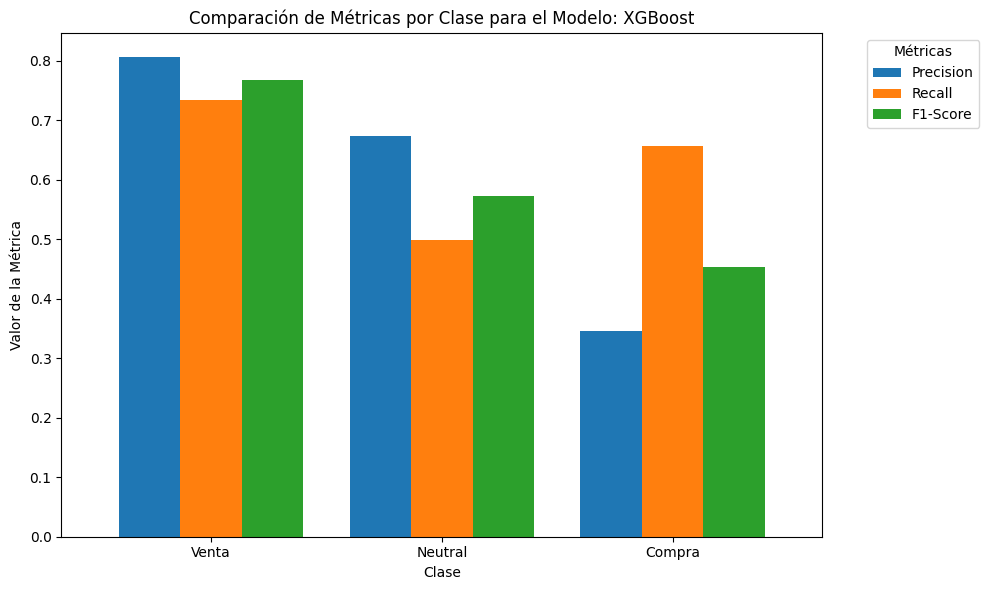

<Figure size 1000x600 with 0 Axes>

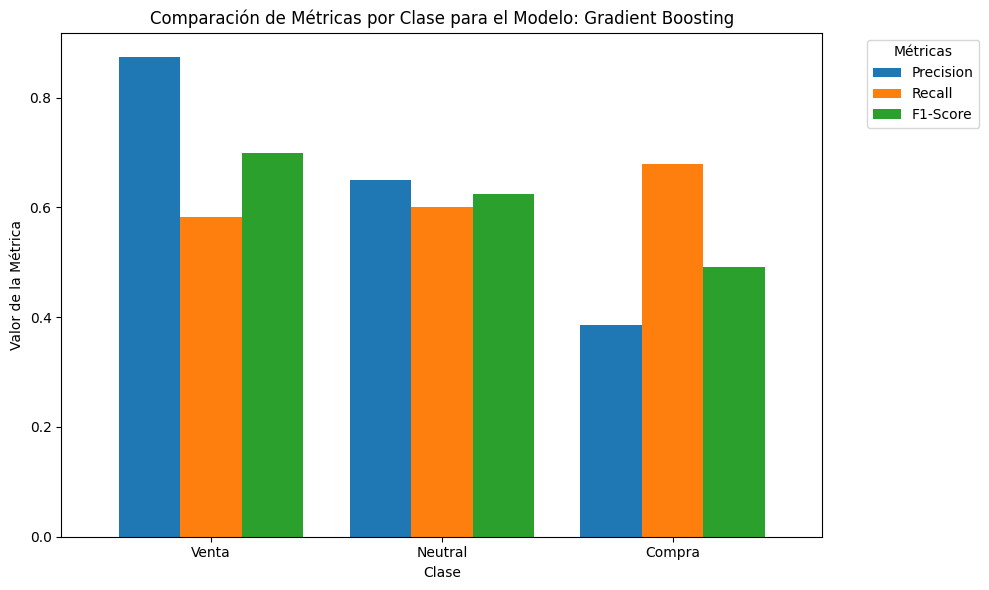

<Figure size 1000x600 with 0 Axes>

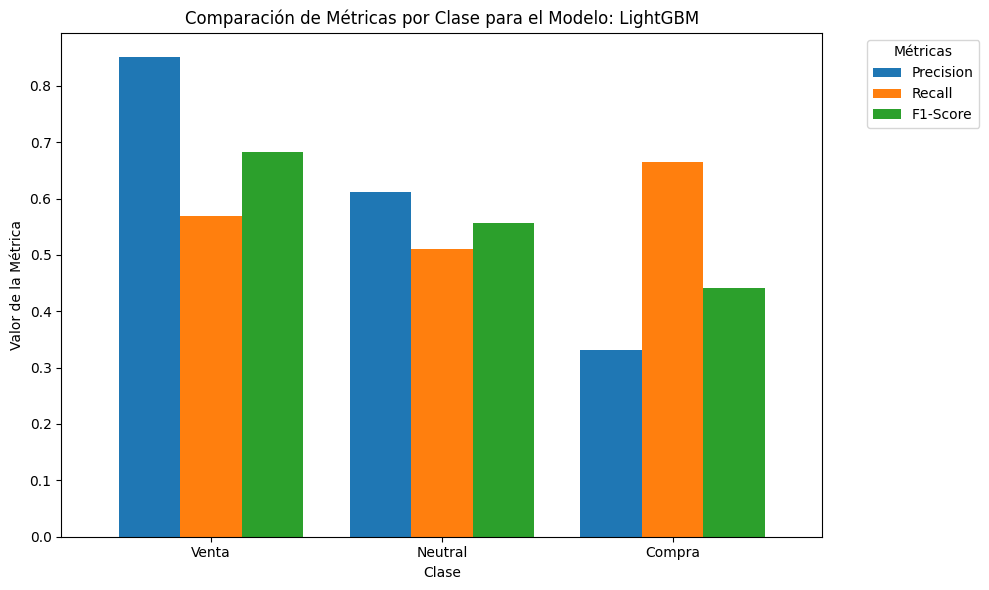

In [ ]:
# Crear un DataFrame vacío para almacenar las métricas por clase
class_metrics = {}

# Definir el diccionario para mapear las etiquetas numéricas a las de clase
label_mapping = {
    0: "Venta",
    1: "Neutral",
    2: "Compra"
}

# Extraer las métricas por clase para cada modelo
for model_name, y_pred_2w in predictions_2w.items():
    # Obtener el reporte de clasificación por clase
    report_2w = classification_report(y_test_2w, y_pred_2w, output_dict=True, zero_division=1)
    
    # Filtrar las métricas relevantes (precision, recall, f1-score) para cada clase
    for label in ['0', '1', '2']:  # 0: Venta, 1: Neutral, 2: Compra
        class_label = label_mapping[int(label)]  # Convertir el número a la etiqueta correspondiente
        class_metrics.setdefault(model_name, {})[class_label] = {
            "Precision": report_2w[label]['precision'],
            "Recall": report_2w[label]['recall'],
            "F1-Score": report_2w[label]['f1-score']
        }

# Crear una gráfica para cada modelo
for model_name, metrics in class_metrics.items():
    # Convertir las métricas por clase a un DataFrame
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')

    # Crear una figura para el gráfico
    plt.figure(figsize=(10, 6))

    # Graficar las métricas de precisión, recall y f1-score por clase para el modelo actual
    metrics_df.plot(kind='bar', figsize=(10, 6), width=0.8)

    # Añadir título y etiquetas
    plt.title(f'Comparación de Métricas por Clase para el Modelo: {model_name}')
    plt.xlabel('Clase')
    plt.ylabel('Valor de la Métrica')
    plt.xticks(rotation=0)  # No rotar las etiquetas para que se vean bien
    plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajustar la visualización del gráfico para que todo se vea bien
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()


In [ ]:
# Mostrar la cantidad de cada predicción por modelo
prediction_counts_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    unique, counts = np.unique(
        y_pred_2w, return_counts=True
    )  # Contar la frecuencia de cada predicción
    prediction_counts_2w[model_name] = dict(zip(unique, counts))

In [ ]:
# Crear un DataFrame para almacenar las predicciones y los valores reales
comparison_df_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    # Crear un DataFrame con las predicciones y las clases reales
    comparison_df_2w[model_name] = pd.DataFrame(
        {
            "Real": y_test_2w,  # Valores reales
            "Predicción": y_pred_2w,  # Predicciones del modelo
        }
    )

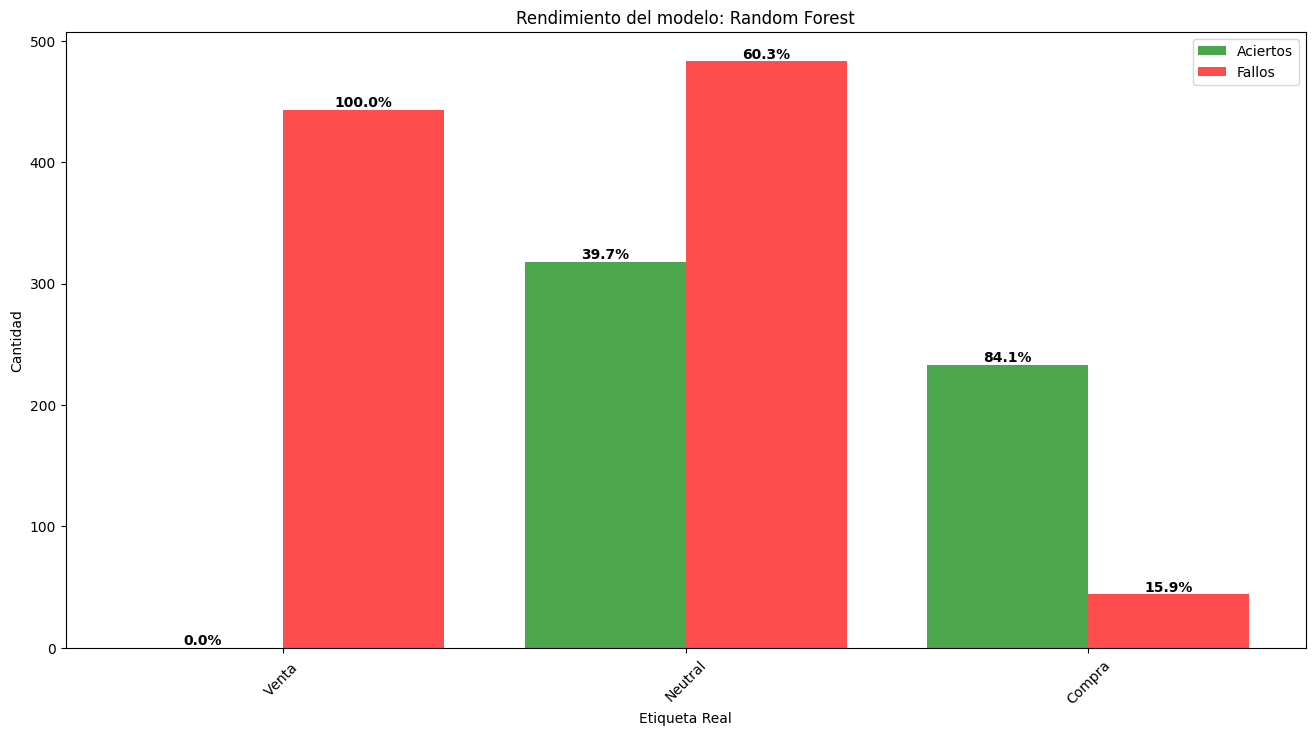

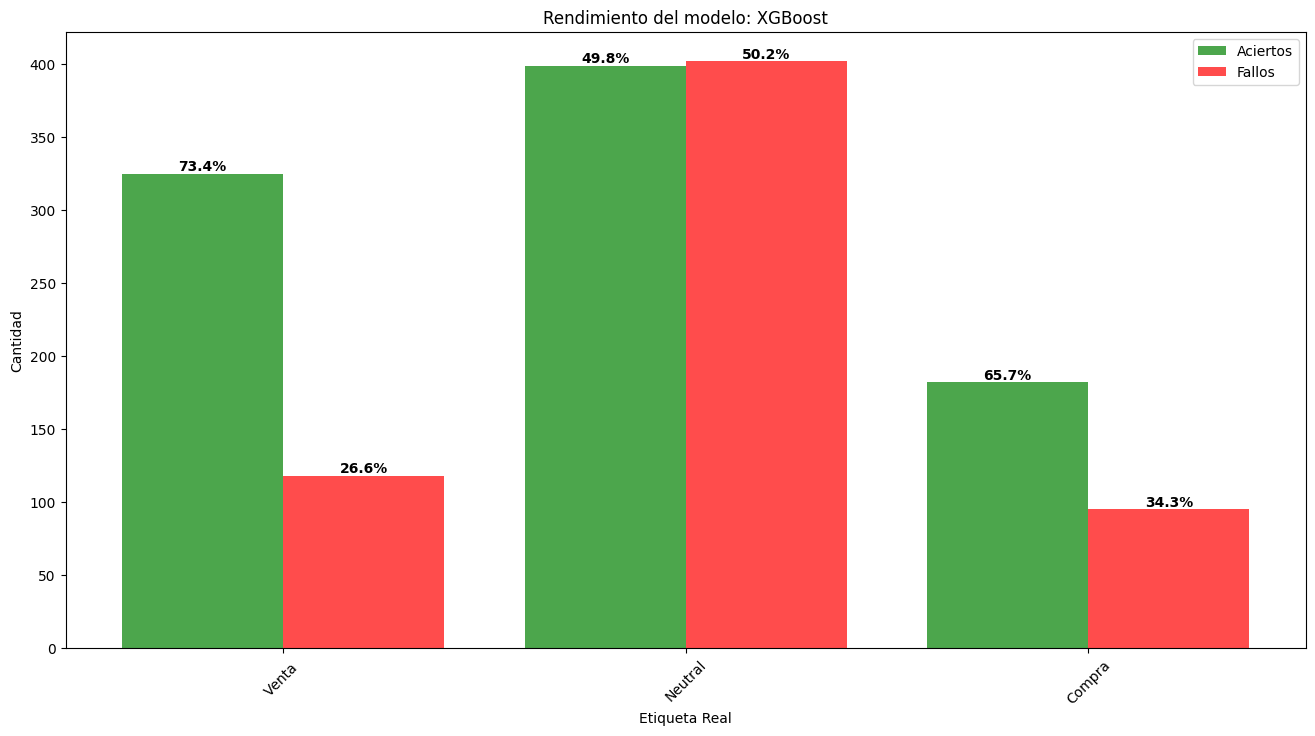

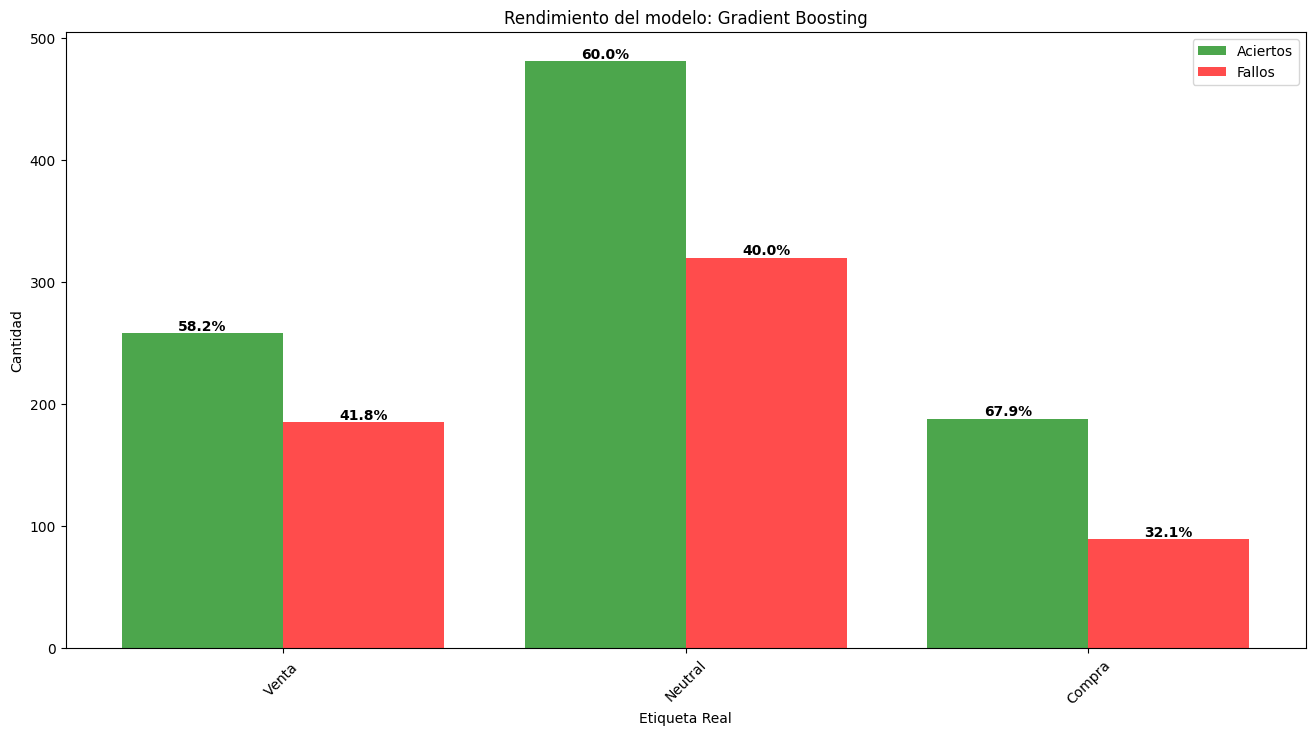

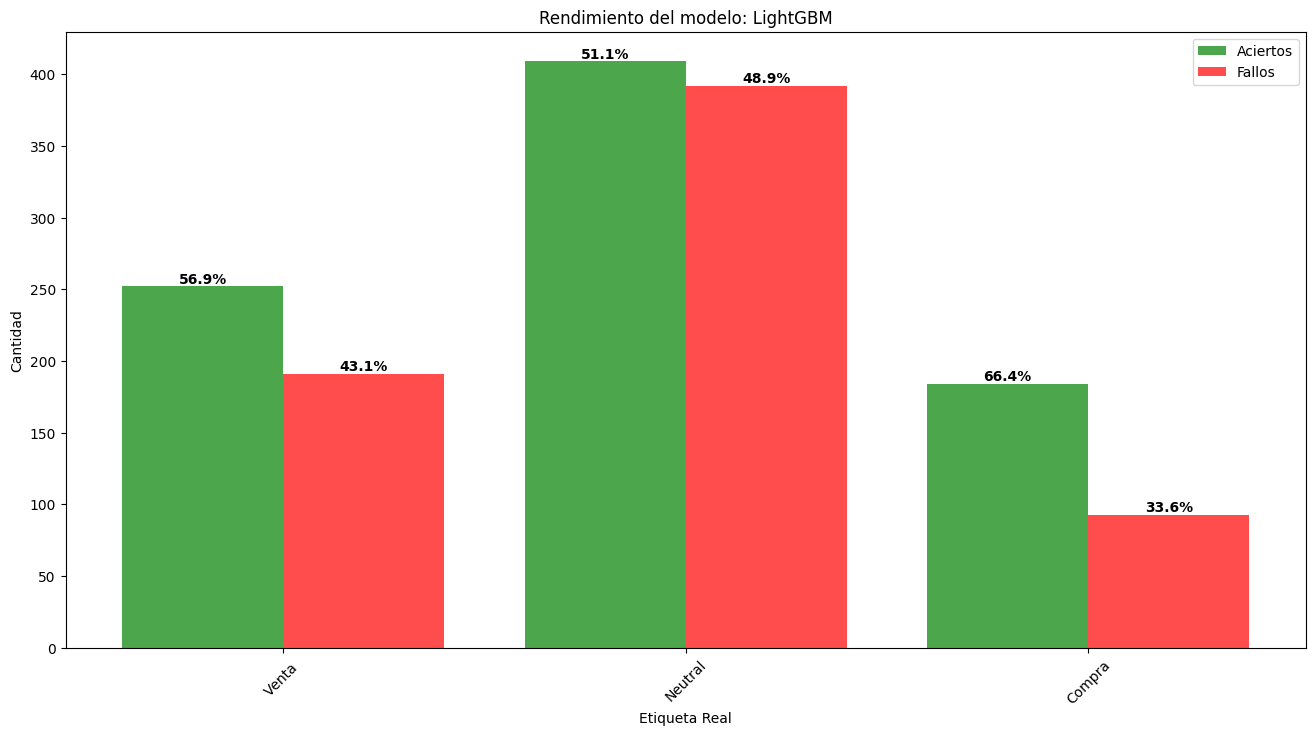

In [ ]:
# 🔹 Diccionario para mapear números a etiquetas (con orden específico)
label_mapping = {
    0: "Venta ",
    1: "Neutral",
    2: "Compra",
}

# Lista ordenada de etiquetas
ordered_labels = list(label_mapping.values())

# 🔹 Crear un DataFrame para almacenar las comparaciones
comparison_df_2w = {}

for model_name, y_pred_2w in predictions_2w.items():
    # Crear DataFrame con valores reales y predicciones
    df = pd.DataFrame({"Real": y_test_2w, "Predicción": y_pred_2w})

    # Convertir los valores numéricos a etiquetas de texto
    df["Real"] = df["Real"].map(label_mapping)
    df["Predicción"] = df["Predicción"].map(label_mapping)

    # Definir el orden de las categorías para "Real" y "Predicción"
    df["Real"] = pd.Categorical(df["Real"], categories=ordered_labels, ordered=True)
    df["Predicción"] = pd.Categorical(
        df["Predicción"], categories=ordered_labels, ordered=True
    )

    # Guardar en el diccionario
    comparison_df_2w[model_name] = df

# 🔹 Crear una gráfica para comparar aciertos y errores por cada etiqueta
for model_name, df in comparison_df_2w.items():
    df["Correcto"] = df["Real"] == df["Predicción"]  # True si acertó, False si falló

    # Contar aciertos y errores por etiqueta
    results = (
        df.groupby(["Real", "Correcto"], observed=False).size().unstack(fill_value=0)
    )

    # Asegurar que las columnas existen y renombrarlas si es necesario
    results = results.rename(columns={True: "Aciertos", False: "Fallos"})

    # Si faltan columnas, agregarlas con 0
    results = results.reindex(columns=["Aciertos", "Fallos"], fill_value=0)

    # Calcular porcentajes
    total_counts = results.sum(axis=1)
    percentages = results.div(total_counts, axis=0) * 100  # Convertir a porcentaje

    # 🔹 Gráfica con barras separadas (verde a la izquierda, roja a la derecha)
    x = np.arange(len(ordered_labels))  # Posiciones de las etiquetas
    width = 0.4  # Ancho de las barras

    plt.figure(figsize=(16, 8))

    # Barras de aciertos (izquierda)
    bars1 = plt.bar(
        x - width / 2,
        results["Aciertos"],
        width=width,
        color="green",
        alpha=0.7,
        label="Aciertos",
    )

    # Barras de fallos (derecha)
    bars2 = plt.bar(
        x + width / 2,
        results["Fallos"],
        width=width,
        color="red",
        alpha=0.7,
        label="Fallos",
    )

    # 🔹 Añadir los porcentajes sobre cada barra
    for bar, pct1 in zip(bars1, percentages["Aciertos"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{pct1:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    for bar, pct2 in zip(bars2, percentages["Fallos"]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{pct2:.1f}%",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # 🔹 Formato final de la gráfica
    plt.title(f"Rendimiento del modelo: {model_name}")
    plt.xlabel("Etiqueta Real")
    plt.ylabel("Cantidad")
    plt.xticks(x, ordered_labels, rotation=45)  # Etiquetas con rotación
    plt.legend()
    plt.show()

In [ ]:
# Obtener los datos de ayer (última fila)
yesterday_data = data_2w.iloc[-1:]

# Extraer fecha y precio de cierre de ayer
yesterday_date = yesterday_data["Date"].values[0]
yesterday_close = yesterday_data["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday = yesterday_data.drop(
    columns=["Future_Change_2w", "Future_Class_2w", "Date"]
)
X_yesterday_np = (
    X_yesterday.to_numpy()
)  # Convertir a numpy para evitar warnings de Scikit-Learn

# Hacer predicciones con cada modelo
future_predictions = {}

for model_name, model in models.items():
    future_prediction = model.predict(X_yesterday_np)[
        0
    ]  # Obtener la predicción numérica

    future_predictions[model_name] = (
        f"📉 Caída (< {percentiles_2w[0]:.2f}%)"
        if future_prediction == 0
        else (
            f"➖  Sin cambios significativos ({percentiles_2w[0]:.2f}% a {percentiles_2w[1]:.2f}%)"
            if future_prediction == 1
            else (f"➖  Sin cambios significativos (>{percentiles_2w[1]:.2f}%)")
        )
    )

# Mostrar los resultados con fecha formateada correctamente
print(
    f"\n📅 Fecha de la última observación: {pd.to_datetime(yesterday_date).strftime('%Y-%m-%d %H:%M')}"
)
print(f"💰 Precio de cierre: {yesterday_close:.2f} USD\n")

print("🔮 Predicciones de 'Future_Class_2w' para los datos de ayer:")
for model_name, prediction in future_predictions.items():
    print(f"⚡ {model_name}: {prediction}")


📅 Fecha de la última observación: 2025-03-31 19:30
💰 Precio de cierre: 156.12 USD

🔮 Predicciones de 'Future_Class_2w' para los datos de ayer:
⚡ Random Forest: ➖  Sin cambios significativos (>4.55%)
⚡ XGBoost: ➖  Sin cambios significativos (-3.35% a 4.55%)
⚡ Gradient Boosting: ➖  Sin cambios significativos (-3.35% a 4.55%)
⚡ LightGBM: ➖  Sin cambios significativos (-3.35% a 4.55%)


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Últimos 350 registros para graficar historial
data_last_350 = data_2w.tail(500)

# Obtener datos de ayer (última fila)
yesterday_data_2w = data_2w.iloc[-1:]
yesterday_date_2w = yesterday_data_2w["Date"].values[0]
yesterday_close_2w = yesterday_data_2w["Close"].values[0]

# Asegurar que no incluimos variables de futuro
X_yesterday_2w = yesterday_data.drop(
    columns=["Future_Change_2w", "Future_Class_2w", "Date"]
)
X_yesterday_2w_np = X_yesterday.to_numpy()

# Definir cuántos pasos futuros extenderemos la banda
future_steps_2w = 70
last_date = data_last_350["Date"].max()  # Última fecha en la data histórica
future_dates_2w = pd.date_range(start=last_date, periods=future_steps_2w + 1, freq="h")[
    1:
]

In [ ]:
def check_prediction_for_specific_day(data, x, periods_ahead=70):
    """
    Verifica la predicción de los modelos para una fecha específica `x` períodos atrás
    y su resultado futuro en 'Future_Class_2w', mostrando ambos cierres.
    """
    # Verificar si hay suficientes datos hacia atrás
    if x >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return

    # Obtener los datos de hace `x` períodos
    specific_day_data = data.iloc[-x]  # Últimos `x` períodos hacia atrás
    specific_date = specific_day_data["Date"]

    # Calcular la fecha futura correctamente
    future_index = -x + periods_ahead  # 70 períodos adelante (~2 semanas en 1h)

    if future_index < len(data):
        future_day_data = data.iloc[future_index]
        future_date = future_day_data["Date"]
        close_future = future_day_data["Close"]
    else:
        future_date = "N/A"
        close_future = None  # No hay suficiente data para ver el cierre futuro

    # Seleccionar características para el modelo (excluyendo la columna objetivo y la fecha)
    features = [
        col
        for col in data.columns
        if col not in ["Future_Change_2w", "Future_Class_2w", "Date"]
    ]
    X_specific_day = specific_day_data[features]

    # Realizar predicciones con cada modelo
    specific_day_predictions_2w = {}
    for model_name, model in models.items():
        future_prediction = model.predict([X_specific_day])
        specific_day_predictions_2w[model_name] = future_prediction[
            0
        ]  # Guardar la predicción

    # Obtener la clase real y el cambio futuro
    real_class_future = specific_day_data["Future_Class_2w"]
    real_change_future = specific_day_data["Future_Change_2w"]

    # Determinar en qué rango cae el cambio real según los percentiles
    real_class_from_change = (
        0
        if real_change_future <= percentiles_2w[0]
        else 1 if real_change_future <= percentiles_2w[1] else 2
    )

    # 📌 Mostrar resultados con fecha real y cierres
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {specific_day_data['Close']:.2f} USD")
    print(
        f"📅 Fecha futura (2 semanas después): {future_date if future_date != 'N/A' else 'No disponible'}"
    )

    if close_future is not None:
        print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")

    print(f"🔹 Clase real 'Future_Class_2w': {real_class_future}")
    print(
        f"🔹 Cambio real: {real_change_future:.2f}% -> Clasificado como {real_class_from_change}"
    )

    print(f"\n📊 Percentiles para clasificación:")
    for i, perc in enumerate(percentiles_2w):
        print(f"   🔹 Percentil {i}: {perc:.2f}%")

    print("\n🔍 Predicciones de los modelos:")
    for model_name, prediction in specific_day_predictions_2w.items():
        resultado = "✅ Acertó!" if prediction == real_class_future else "❌ No acertó."
        print(
            f"   {model_name}: Predicción = {prediction} | Real = {real_class_future} -> {resultado}"
        )

    # 🚀 Depuración si hay errores en la fecha futura
    if isinstance(future_date, str) or future_date.year < 2025:
        print("\n⚠️ Posible error en el cálculo de la fecha futura.")
        print(f"   Índice futuro esperado: {future_index}")
        print(f"   Fecha estimada en DataFrame: {future_date}")


# 🔹 **Ejemplo de uso:**
print(data_2w.shape)

check_prediction_for_specific_day(data_2w, x=87)  # Verifica hace 100 períodos (~4-5 días hábiles en 1h)

(5037, 73)

📅 Fecha evaluada: 2025-03-13 17:30:00
💰 Cierre en la fecha evaluada: 165.50 USD
📅 Fecha futura (2 semanas después): 2025-03-27 17:30:00+00:00
💰 Cierre en la fecha futura: 164.57 USD
🔹 Clase real 'Future_Class_2w': 1
🔹 Cambio real: -0.56% -> Clasificado como 1

📊 Percentiles para clasificación:
   🔹 Percentil 0: -3.35%
   🔹 Percentil 1: 4.55%

🔍 Predicciones de los modelos:
   Random Forest: Predicción = 2 | Real = 1 -> ❌ No acertó.
   XGBoost: Predicción = 2 | Real = 1 -> ❌ No acertó.
   Gradient Boosting: Predicción = 2 | Real = 1 -> ❌ No acertó.
   LightGBM: Predicción = 2 | Real = 1 -> ❌ No acertó.


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(



📅 Fecha evaluada: 2024-11-25 16:30:00
💰 Cierre en la fecha evaluada: 168.57 USD
📅 Fecha futura (2 semanas después): 2024-12-10 20:30:00
💰 Cierre en la fecha futura: 186.52 USD
📈 Cambio real en porcentaje: 10.65%

🔍 Predicciones de los modelos y precios proyectados:
Random Forest: Predicción = 2 | Rango esperado = 176.23 - 206.71 USD
🎯 Rango de percentiles: 4.55% - 22.63% -> ✅ Acertó!
XGBoost: Predicción = 2 | Rango esperado = 176.23 - 206.71 USD
🎯 Rango de percentiles: 4.55% - 22.63% -> ✅ Acertó!
Gradient Boosting: Predicción = 2 | Rango esperado = 176.23 - 206.71 USD
🎯 Rango de percentiles: 4.55% - 22.63% -> ✅ Acertó!
LightGBM: Predicción = 2 | Rango esperado = 176.23 - 206.71 USD
🎯 Rango de percentiles: 4.55% - 22.63% -> ✅ Acertó!


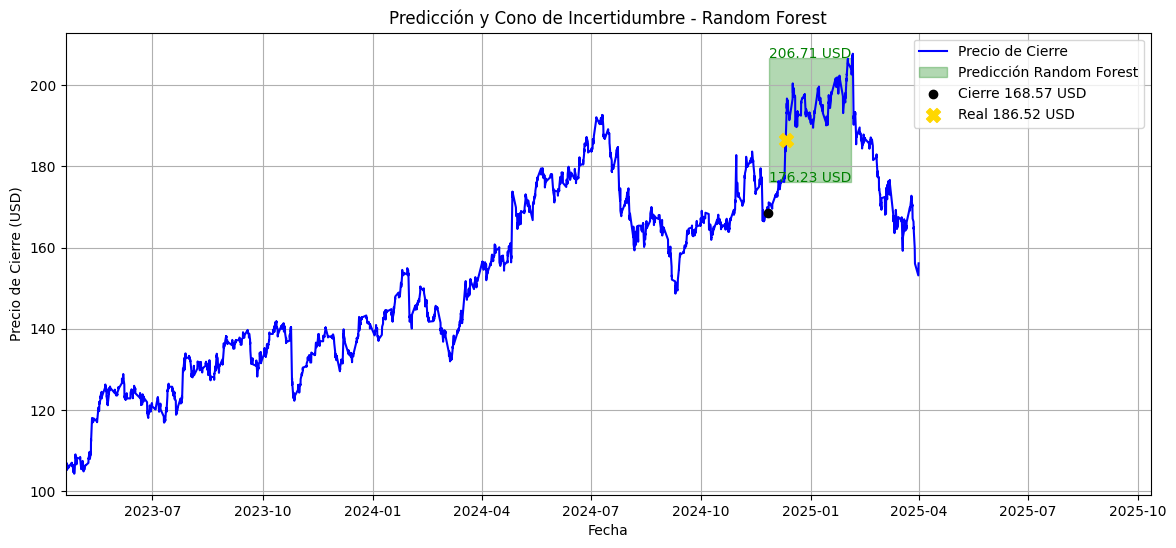

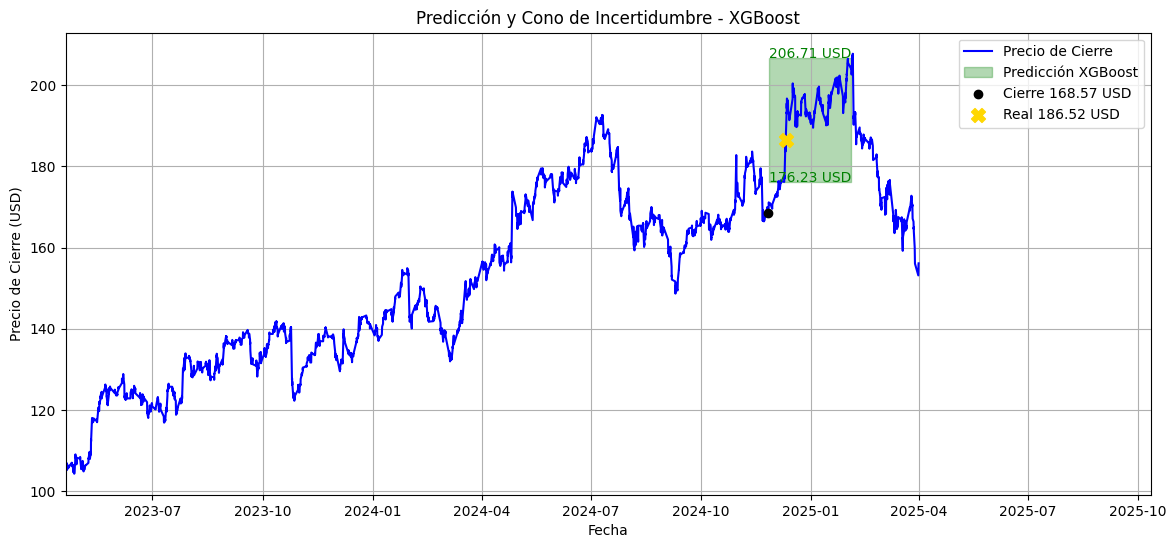

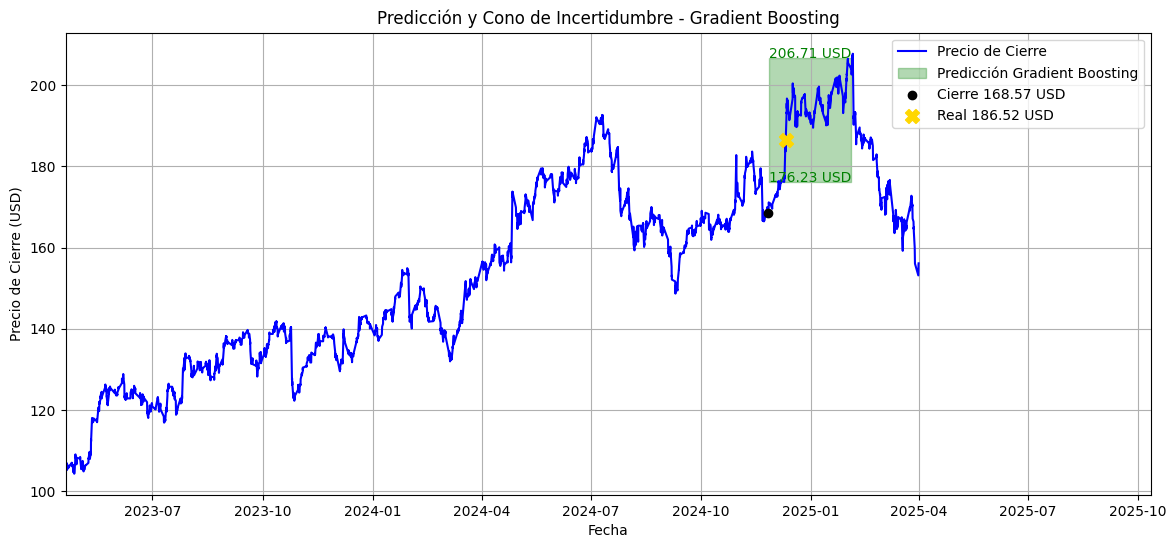

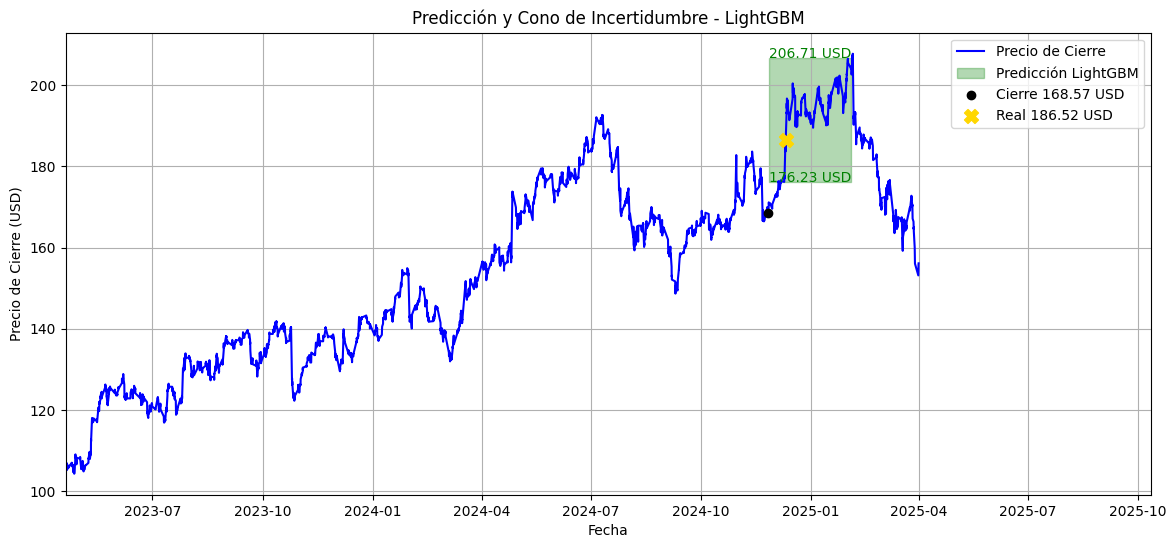

In [ ]:
def check_prediction_with_cone(data, x, periods_ahead=70, num_days_to_plot=200):
    if -x >= len(data) or -x + periods_ahead >= len(data):
        print(f"⚠️ No hay suficientes datos para verificar {x} períodos atrás.")
        return

    # 🔹 Obtener datos del punto de partida
    specific_day_data = data.iloc[-x]
    specific_date = specific_day_data["Date"]
    close_actual = specific_day_data["Close"]
    
    min_change = abs(data_2w['Past_Change_2w'].min())  # Valor absoluto del mínimo
    max_change = abs(data_2w['Past_Change_2w'].max())  # Valor absoluto del máximo

    # 🔹 Obtener datos del punto futuro donde se verificará la predicción
    future_day_data = data.iloc[-x + periods_ahead]
    future_date = future_day_data["Date"]
    close_future = future_day_data["Close"]

    # 🔹 Calcular el cambio real en porcentaje
    real_change_percent = ((close_future - close_actual) / close_actual) * 100

    # 🔹 Extraer características para la predicción
    features = [
        col
        for col in data.columns
        if col not in ["Future_Change_2w", "Future_Class_2w", "Date"]
    ]
    X_specific_day = specific_day_data[features]

    specific_day_predictions = {}
    projected_prices = {}

    for model_name, model in models.items():
        future_prediction = int(model.predict([X_specific_day])[0])
        specific_day_predictions[model_name] = future_prediction

        # 🔹 Determinar el rango según la predicción
        if future_prediction == 0:  # Caída muy fuerte
            color = "red"
            pred_range = (percentiles_2w[0] - min_change, percentiles_2w[0])
        elif future_prediction == 1:  # Caída moderada
            color = "orangered"
            pred_range = (percentiles_2w[0], percentiles_2w[1])
        else:  # Subida muy fuerte
            color = "green"
            pred_range = (percentiles_2w[1], percentiles_2w[1] + max_change)

        projected_price_min = close_actual * (1 + (pred_range[0] / 100))
        projected_price_max = close_actual * (1 + (pred_range[1] / 100))
        projected_prices[model_name] = (
            projected_price_min,
            projected_price_max,
            pred_range[0],
            pred_range[1],
        )

    # 📌 Mostrar resultados
    print(f"\n📅 Fecha evaluada: {specific_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha evaluada: {close_actual:.2f} USD")
    print(f"📅 Fecha futura (2 semanas después): {future_date.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"💰 Cierre en la fecha futura: {close_future:.2f} USD")
    print(f"📈 Cambio real en porcentaje: {real_change_percent:.2f}%")

    print("\n🔍 Predicciones de los modelos y precios proyectados:")
    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, percentile_min, percentile_max = projected_prices[model_name]

        if percentile_min <= real_change_percent <= percentile_max:
            resultado = "✅ Acertó!"
        else:
            resultado = "❌ No acertó."

        print(f"{model_name}: Predicción = {prediction} | Rango esperado = {price_min:.2f} - {price_max:.2f} USD")
        print(f"🎯 Rango de percentiles: {percentile_min:.2f}% - {percentile_max:.2f}% -> {resultado}")

    # 🚀 Graficar con el cono de predicción (una gráfica por modelo)
    future_steps = periods_ahead
    future_dates = pd.date_range(start=specific_date, periods=future_steps + 1, freq="D")[1:]

    for model_name, prediction in specific_day_predictions.items():
        price_min, price_max, _, _ = projected_prices[model_name]

        # 🔹 Graficar el historial del precio de cierre
        plt.figure(figsize=(14, 6))
        plt.plot(
            data.iloc[-num_days_to_plot:]["Date"],
            data.iloc[-num_days_to_plot:]["Close"],
            label="Precio de Cierre",
            color="blue",
        )

        # 🔹 Graficar el cono de predicción
        lower_bound = [
            close_actual * (1 + (projected_prices[model_name][2] / 100))
        ] * len(future_dates)
        upper_bound = [
            close_actual * (1 + (projected_prices[model_name][3] / 100))
        ] * len(future_dates)

        plt.fill_between(
            future_dates,
            lower_bound,
            upper_bound,
            color=color,
            alpha=0.3,
            label=f"Predicción {model_name}",
        )

        # 🔹 Etiquetas de los valores proyectados en el extremo derecho
        plt.text(
            future_dates[-1],
            lower_bound[-1],
            f"{lower_bound[-1]:.2f} USD",
            color=color,
            fontsize=10,
            ha="right",
        )
        plt.text(
            future_dates[-1],
            upper_bound[-1],
            f"{upper_bound[-1]:.2f} USD",
            color=color,
            fontsize=10,
            ha="right",
        )

        # 🔹 Marcar el punto de inicio de la predicción y el cierre real futuro
        plt.scatter(
            specific_date,
            close_actual,
            color="black",
            zorder=3,
            label=f"Cierre {close_actual:.2f} USD",
        )
        plt.scatter(
            future_date,
            close_future,
            color="gold",
            marker="X",
            s=100,
            zorder=4,
            label=f"Real {close_future:.2f} USD",
        )

        # Configuración del gráfico
        plt.xlabel("Fecha")
        plt.ylabel("Precio de Cierre (USD)")
        plt.title(f"Predicción y Cono de Incertidumbre - {model_name}")
        plt.legend()
        plt.grid(True)

        plt.xlim(
            data.iloc[-num_days_to_plot]["Date"],
            future_dates[-1] + pd.Timedelta(days=250),
        )
        plt.show()


# Llamada a la función con los parámetros deseados
check_prediction_with_cone(data_2w, x=585, periods_ahead=70, num_days_to_plot=3400)